# Analysis — Mental Health in Tech

## Summary

### Objectives
The goal was to practice exploratory data analysis (EDA) and data visualization while drawing actionable insights about workplace mental health.

### 🔑 Key Findings

**Demographics**
- Age skewed toward younger working professionals.
- Gender imbalance in respondents (tech-heavy male representation).
  - Majority respondents aged 18–35 (≈65%).
  - Gender imbalance: ~70% male, ~25% female, ~5% non-binary/other.

**Prevalence of Mental Health Disorders**
- Significant proportion of respondents (Approx 40%) reported experiencing or being diagnosed with a mental health condition.
- Many reported interference of mental health with daily work and productivity.

**Workplace Comfort & Stigma**
- Respondents were less comfortable discussing mental health with employers/supervisors (~35%) compared to coworkers or family/friends (~70%).
- Stigma and fear of negative career consequences remained a barrier.

**Employer Support**
- 70% agreed employers supported physical health, but only 40% agreed on mental health support.

**Trends Across Surveys (2017 vs 2019)**
- Gradual improvement in willingness to discuss mental health at work.
- Some positive shifts in employer recognition of mental health importance.


### 📌 Key Takeaways
- Workplace stigma persists: Mental health conversations are still riskier with managers than with peers.
  - Only ~1 in 3 respondents feel safe disclosing to supervisors.
- Support gap: Employers provide more visible support for physical health than mental health.
  - Employers are 30pp more likely to be seen as supporting physical health vs. mental health.
- Need for policies: Training, clear policies, and cultural changes are necessary to normalize mental health discussions.
- Data-driven monitoring: Continued survey analysis is vital to track progress over time.


## Limitations of the Data
There were a number of limitations with the dataset:

- Limited Data:
  - The number of respondents varied wildly between 2014 and 2016
- Lacking Consistency
  - Many fields lack consistent responses over tine making year to year comparisons difficult
- Stale Data
  - The latest survey responses were from 2019 which is a full 6 years ago.
  - Many events have happened since this data was collected such as Covid-19, Working From Home culture which would have greatly affected tech workers.
  - This makes this data much less applicable for current day insights.



# Imports

In [145]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("anth7310/mental-health-in-the-tech-industry")

#print("Path to dataset files:", path)

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
import helper_functions as hf
import warnings

In [147]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Data Preparation

### Load & Query Raw Data

In [148]:
import duckdb

sqlite_path = "mental_health.sqlite"

con = duckdb.connect()
con.execute("INSTALL sqlite;")
con.execute("LOAD sqlite;")

# Attach the SQLite database
con.execute(f"CALL sqlite_attach('{sqlite_path}');")



In [149]:
# read the SQL script file
with open("country_continent.sql", "r", encoding="utf-8") as f:
    sql_script = f.read()

# run the whole script
con.execute(sql_script)

# sanity check
con.execute("SELECT count(*) FROM country_continent").fetchdf()

,count_star()
0,195


In [150]:
# Now list tables
tables = con.execute("SHOW TABLES;").fetchdf()
print(tables)


                name
0             Answer
1           Question
2             Survey
3  country_continent


In [151]:
#question_df = con.execute("""SELECT * FROM Question""").fetchdf()

# Open in Excel to better look through questions of interest
#question_df.to_csv('questions_df.csv')

In [152]:
# Querying
# How many respondents answer over many surveys?
# No, we can assume each respondent is unique per year, the total count checks out so no duplicate user_ids

con.execute("""

    SELECT
        a.SurveyID,
        MIN(a.UserID) AS min_userid,
        MAX(a.UserID) AS max_userid,
        count(*) AS vol

    FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

    GROUP BY ALL

    ORDER BY 1 ASC

""").fetchdf()

,SurveyID,min_userid,max_userid,vol
0,2014,1,1260,32760
1,2016,1261,2693,88238
2,2017,2694,3449,57456
3,2018,3450,3866,31692
4,2019,3867,4218,26752


In [153]:
# Querying
# How many respondents answer over many surveys?

con.execute("""

    SELECT
        q.questiontext,
        a.AnswerText,
        COUNT(*) AS vol,


    FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

    WHERE a.QuestionID IN (18,99)

    GROUP BY ALL
    ORDER BY 2,1




""").fetchdf()

,questiontext,AnswerText,vol
0,Would you feel comfortable discussing a mental...,-1,504
1,Would you feel comfortable discussing a mental...,Maybe,1053
2,Would you be willing to discuss a mental healt...,No,260
3,Would you feel comfortable discussing a mental...,No,719
4,Would you be willing to discuss a mental healt...,Some of them,775
5,Would you be willing to discuss a mental healt...,Yes,225
6,Would you feel comfortable discussing a mental...,Yes,682


In [154]:
# Querying
# How many respondents answer over many surveys?

con.execute("""

    SELECT
        q.questiontext,
        a.AnswerText,
        COUNT(*) AS vol,


    FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

    WHERE a.QuestionID IN (117)

    GROUP BY ALL
    ORDER BY 2,1




""").fetchdf()

,questiontext,AnswerText,vol
0,Which of the following best describes your wor...,Back-end Developer,737
1,Which of the following best describes your wor...,Designer,135
2,Which of the following best describes your wor...,Dev Evangelist/Advocate,99
3,Which of the following best describes your wor...,DevOps/SysAdmin,282
4,Which of the following best describes your wor...,Executive Leadership,101
5,Which of the following best describes your wor...,Front-end Developer,502
6,Which of the following best describes your wor...,HR,12
7,Which of the following best describes your wor...,One-person shop,161
8,Which of the following best describes your wor...,Other,187
9,Which of the following best describes your wor...,Sales,31


In [155]:
# Querying
# How many respondents answer over many surveys?

con.execute("""

WITH base AS (
        SELECT
            a.SurveyID,
            a.UserID,

            -- Demographics
            MAX(CASE WHEN a.QuestionID = 1 THEN a.AnswerText ELSE NULL END) AS DEM_age,
            MAX(CASE WHEN a.QuestionID = 2 THEN a.AnswerText ELSE NULL END) AS DEM_gender,
            MAX(CASE WHEN a.QuestionID = 50 THEN a.AnswerText ELSE NULL END) AS DEM_country,
            MAX(CASE WHEN a.QuestionID = 89 THEN a.AnswerText ELSE NULL END) AS DEM_race,
            MAX(CASE WHEN a.QuestionID = 93 THEN a.AnswerText ELSE NULL END) AS DEM_remote_50plus,
            MAX(CASE WHEN a.QuestionID = 118 THEN a.AnswerText ELSE NULL END) AS DEM_remote,
            MAX(CASE WHEN a.QuestionID = 117 THEN a.AnswerText ELSE NULL END) AS DEM_position,

            -- Personal Mental Health
            MAX(CASE WHEN a.QuestionID = 33 THEN a.AnswerText ELSE NULL END) AS PMH_current_mh_disorder,
            MAX(CASE WHEN a.QuestionID = 34 THEN a.AnswerText ELSE NULL END) AS PMH_diagnosed_mh_disorder,
            MAX(CASE WHEN a.QuestionID = 48 THEN a.AnswerText ELSE NULL END) AS PMH_mh_disorder_interference_treated,
            MAX(CASE WHEN a.QuestionID = 54 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_productivity,
            MAX(CASE WHEN a.QuestionID = 55 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_work_pct,
            MAX(CASE WHEN a.QuestionID = 78 THEN a.AnswerText ELSE NULL END) AS PMH_openly_identified_mh,
            MAX(CASE WHEN a.QuestionID = 79 THEN a.AnswerText ELSE NULL END) AS PMH_mh_identification_career_effect,
            MAX(CASE WHEN a.QuestionID = 92 THEN a.AnswerText ELSE NULL END) AS PMH_mh_condition_interference,

            -- Comfort Discussing Mental Health
            MAX(CASE WHEN a.QuestionID = 18 THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_coworkers,
            MAX(CASE WHEN a.QuestionID = 19 THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_supervisor,
            MAX(CASE WHEN a.QuestionID = 28 THEN a.AnswerText ELSE NULL END) AS DMH_willing_mh_supervisor_past,
            MAX(CASE WHEN a.QuestionID = 30 THEN a.AnswerText ELSE NULL END) AS DMH_willing_share_friends_family,
            MAX(CASE WHEN a.QuestionID = 58 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_employer,
            MAX(CASE WHEN a.QuestionID = 60 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_coworkers,
            MAX(CASE WHEN a.QuestionID = 62 THEN a.AnswerText ELSE NULL END) AS DMH_coworker_discussed_mh,
            MAX(CASE WHEN a.QuestionID = 70 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_prev_employer,
            MAX(CASE WHEN a.QuestionID = 99 THEN a.AnswerText ELSE NULL END) AS DMH_willing_mh_coworkers,
            MAX(CASE WHEN a.QuestionID = 100 THEN a.AnswerText ELSE NULL END) AS DMH_willing_mh_supervisor,
            MAX(CASE WHEN a.QuestionID = 101 THEN a.AnswerText ELSE NULL END) AS DMH_mh_mention_in_interview,

            -- Employer & Industry Support
            MAX(CASE WHEN a.QuestionID = 56 THEN a.AnswerText ELSE NULL END) AS SUP_unsupportive_response_observed,
            MAX(CASE WHEN a.QuestionID = 64 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_physical,
            MAX(CASE WHEN a.QuestionID = 65 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_mental,
            MAX(CASE WHEN a.QuestionID = 76 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_physical,
            MAX(CASE WHEN a.QuestionID = 77 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_mental,
            MAX(CASE WHEN a.QuestionID = 85 THEN a.AnswerText ELSE NULL END) AS SUP_industry_support_mh,
            MAX(CASE WHEN a.QuestionID = 91 THEN a.AnswerText ELSE NULL END) AS SUP_employer_seriousness_mh_vs_physical,
            MAX(CASE WHEN a.QuestionID = 96 THEN a.AnswerText ELSE NULL END) AS SUP_employer_provides_resources,

            -- Stigma & Negative Consequences
            MAX(CASE WHEN a.QuestionID = 31 THEN a.AnswerText ELSE NULL END) AS STIG_observations_reduce_disclosure,
            MAX(CASE WHEN a.QuestionID = 90 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_physical_employer,
            MAX(CASE WHEN a.QuestionID = 98 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_employer,
            MAX(CASE WHEN a.QuestionID = 104 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_disorder_employer,
            MAX(CASE WHEN a.QuestionID = 105 THEN a.AnswerText ELSE NULL END) AS STIG_observed_neg_conseq_coworkers,
            MAX(CASE WHEN a.QuestionID = 112 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_coworker_prev_workplace,

            -- Physical Health Comparisons
            MAX(CASE WHEN a.QuestionID = 29 THEN a.AnswerText ELSE NULL END) AS willing_physical_employer_interview,

            FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

            WHERE a.QuestionID IN (1,2,18,19,28,29,30,31,33,34,48,50,54,55,56,58,60,62,64,65,70,76,77,78,79,85,89,90,91,92,93,96,98,99,100,101,104,105,112,118,117)

            GROUP BY 1,2

)

SELECT SurveyID, DEM_position, count(*) as vol FROM base GROUP BY ALL ORDER BY 1


""").fetchdf()

,SurveyID,DEM_position,vol
0,2014,None,1260
1,2016,Back-end Developer,263
2,2016,Executive Leadership,49
3,2016,Support,168
4,2016,Sales,11
5,2016,Supervisor/Team Lead,233
6,2016,Other,148
7,2016,HR,5
8,2016,Front-end Developer,303
9,2016,One-person shop,100


In [156]:
# Querying
# How many respondents answer over many surveys?

con.execute("""
WITH base AS (
    SELECT
        a.SurveyID,
        a.UserID,

        -- Demographics
        MAX(CASE WHEN a.QuestionID = 1   THEN a.AnswerText ELSE NULL END) AS DEM_age,
        MAX(CASE WHEN a.QuestionID = 2   THEN a.AnswerText ELSE NULL END) AS DEM_gender,
        MAX(CASE WHEN a.QuestionID = 50  THEN a.AnswerText ELSE NULL END) AS DEM_country,
        MAX(CASE WHEN a.QuestionID = 89  THEN a.AnswerText ELSE NULL END) AS DEM_race,
        MAX(CASE WHEN a.QuestionID = 93  THEN a.AnswerText ELSE NULL END) AS DEM_remote_50plus,
        MAX(CASE WHEN a.QuestionID = 118 THEN a.AnswerText ELSE NULL END) AS DEM_remote,
        MAX(CASE WHEN a.QuestionID = 117 THEN a.AnswerText ELSE NULL END) AS DEM_position,


        -- Personal Mental Health
        MAX(CASE WHEN a.QuestionID = 33 THEN a.AnswerText ELSE NULL END) AS PMH_current_mh_disorder,
        MAX(CASE WHEN a.QuestionID = 34 THEN a.AnswerText ELSE NULL END) AS PMH_diagnosed_mh_disorder,
        MAX(CASE WHEN a.QuestionID = 48 THEN a.AnswerText ELSE NULL END) AS PMH_mh_disorder_interference_treated,
        MAX(CASE WHEN a.QuestionID = 54 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_productivity,
        MAX(CASE WHEN a.QuestionID = 55 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_work_pct,
        MAX(CASE WHEN a.QuestionID = 78 THEN a.AnswerText ELSE NULL END) AS PMH_openly_identified_mh,
        MAX(CASE WHEN a.QuestionID = 79 THEN a.AnswerText ELSE NULL END) AS PMH_mh_identification_career_effect,
        MAX(CASE WHEN a.QuestionID = 92 THEN a.AnswerText ELSE NULL END) AS PMH_mh_condition_interference,

        -- Comfort Discussing Mental Health
        MAX(CASE WHEN a.QuestionID IN (99,18) THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_coworkers,
        MAX(CASE WHEN a.QuestionID IN (19,100) THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_supervisor,
        MAX(CASE WHEN a.QuestionID = 28 THEN a.AnswerText ELSE NULL END) AS DMH_willing_mh_supervisor_past,
        MAX(CASE WHEN a.QuestionID = 30 THEN a.AnswerText ELSE NULL END) AS DMH_willing_share_friends_family,
        MAX(CASE WHEN a.QuestionID = 58 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_employer,
        MAX(CASE WHEN a.QuestionID = 60 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_coworkers,
        MAX(CASE WHEN a.QuestionID = 62 THEN a.AnswerText ELSE NULL END) AS DMH_coworker_discussed_mh,
        MAX(CASE WHEN a.QuestionID = 70 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_prev_employer,
        MAX(CASE WHEN a.QuestionID = 101 THEN a.AnswerText ELSE NULL END) AS DMH_mh_mention_in_interview,

        -- Employer & Industry Support
        MAX(CASE WHEN a.QuestionID = 56 THEN a.AnswerText ELSE NULL END) AS SUP_unsupportive_response_observed,
        MAX(CASE WHEN a.QuestionID = 64 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_physical,
        MAX(CASE WHEN a.QuestionID = 65 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_mental,
        MAX(CASE WHEN a.QuestionID = 76 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_physical,
        MAX(CASE WHEN a.QuestionID = 77 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_mental,
        MAX(CASE WHEN a.QuestionID = 85 THEN a.AnswerText ELSE NULL END) AS SUP_industry_support_mh,
        MAX(CASE WHEN a.QuestionID = 91 THEN a.AnswerText ELSE NULL END) AS SUP_employer_seriousness_mh_vs_physical,
        MAX(CASE WHEN a.QuestionID = 96 THEN a.AnswerText ELSE NULL END) AS SUP_employer_provides_resources,

        -- Stigma & Negative Consequences
        MAX(CASE WHEN a.QuestionID = 31  THEN a.AnswerText ELSE NULL END) AS STIG_observations_reduce_disclosure,
        MAX(CASE WHEN a.QuestionID = 90  THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_physical_employer,
        MAX(CASE WHEN a.QuestionID = 98  THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_employer,
        MAX(CASE WHEN a.QuestionID = 104 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_disorder_employer,
        MAX(CASE WHEN a.QuestionID = 105 THEN a.AnswerText ELSE NULL END) AS STIG_observed_neg_conseq_coworkers,
        MAX(CASE WHEN a.QuestionID = 112 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_coworker_prev_workplace,

        -- Physical Health Comparisons
        MAX(CASE WHEN a.QuestionID = 29 THEN a.AnswerText ELSE NULL END) AS willing_physical_employer_interview
    FROM Answer AS a

    LEFT JOIN Question AS q
        ON a.QuestionID = q.questionid

    WHERE a.QuestionID IN (
        1,2,18,19,28,29,30,31,33,34,48,50,54,55,56,58,60,62,64,65,
        70,76,77,78,79,85,89,90,91,92,93,96,98,99,100,101,104,105,112,117,118
    )
    GROUP BY 1,2
),

final AS (

SELECT
    SurveyID,
    UserID,

    -- Demographics
    CASE
        WHEN CAST(DEM_age AS int) NOT BETWEEN 18 AND 70 THEN NULL
        ELSE CAST(DEM_age AS int)
    END AS DEM_age,

    CASE
        WHEN LOWER(DEM_gender) = 'male'   THEN 'Male'
        WHEN LOWER(DEM_gender) = 'female' THEN 'Female'
        WHEN LOWER(DEM_gender) LIKE '%binary%'
          OR LOWER(DEM_gender) LIKE '%trans%'
          OR LOWER(DEM_gender) LIKE '%queer%'
          OR LOWER(DEM_gender) LIKE '%gender%'
        THEN 'Non-Binary'
        ELSE 'Other'
    END AS DEM_gender,

    NULLIF(DEM_country, '-1') AS DEM_country,
    cc.continent AS DEM_continent,

    CASE
        WHEN LOWER(DEM_race) IN ('white', 'caucasian', 'european american') THEN 'Caucasian'
        WHEN DEM_race = '-1' THEN NULL
        WHEN DEM_race IS NULL THEN NULL
        ELSE 'Other Ethnicity'
    END AS DEM_race,
    DEM_remote_50plus,
    DEM_remote,
    DEM_position,

    -- Personal Mental Health
    CASE
        WHEN LOWER(PMH_current_mh_disorder) IN ('possibly', 'maybe') THEN 'Maybe'
        ELSE PMH_current_mh_disorder
    END AS PMH_current_mh_disorder,

    NULLIF(PMH_diagnosed_mh_disorder, '-1')      AS PMH_diagnosed_mh_disorder,
    PMH_mh_disorder_interference_treated,
    NULLIF(PMH_mh_affects_productivity, '-1')    AS PMH_mh_affects_productivity,
    NULLIF(PMH_mh_affects_work_pct, '-1')        AS PMH_mh_affects_work_pct,
    NULLIF(PMH_openly_identified_mh, '-1')       AS PMH_openly_identified_mh,
    NULLIF(PMH_mh_identification_career_effect, '-1') AS PMH_mh_identification_career_effect,
    NULLIF(PMH_mh_condition_interference, '-1')  AS PMH_mh_condition_interference,

    -- Comfort Discussing Mental Health
    CASE
        WHEN LOWER(DMH_comfortable_mh_coworkers) = 'some of them' THEN 'Yes'
        ELSE NULLIF(DMH_comfortable_mh_coworkers, '-1')
    END AS DMH_comfortable_mh_coworkers,

    CASE
        WHEN LOWER(DMH_comfortable_mh_supervisor) = 'some of them' THEN 'Yes'
        ELSE NULLIF(DMH_comfortable_mh_supervisor, '-1')
    END AS DMH_comfortable_mh_supervisor,


    NULLIF(DMH_willing_mh_supervisor_past, '-1')     AS DMH_willing_mh_supervisor_past,
    DMH_willing_share_friends_family,
    NULLIF(DMH_discussed_mh_employer, '-1')          AS DMH_discussed_mh_employer,
    NULLIF(DMH_discussed_mh_prev_employer, '-1')     AS DMH_discussed_mh_prev_employer,
    DMH_mh_mention_in_interview,

    -- Employer & Industry Support
    NULLIF(SUP_unsupportive_response_observed, '-1') AS SUP_unsupportive_response_observed,

    CASE
        WHEN CAST(SUP_employer_importance_physical AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_employer_importance_physical AS int)
    END AS SUP_employer_importance_physical,

    CASE
        WHEN CAST(SUP_employer_importance_mental AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_employer_importance_mental AS int)
    END AS SUP_employer_importance_mental,

    CASE
        WHEN CAST(SUP_prev_employer_importance_physical AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_prev_employer_importance_physical AS int)
    END AS SUP_prev_employer_importance_physical,

    CASE
        WHEN CAST(SUP_prev_employer_importance_mental AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_prev_employer_importance_mental AS int)
    END AS SUP_prev_employer_importance_mental,

    CASE
        WHEN CAST(SUP_industry_support_mh AS int) NOT BETWEEN 0 AND 5 THEN NULL
        ELSE CAST(SUP_industry_support_mh AS int)
    END AS SUP_industry_support_mh,

    CASE
        WHEN LOWER(SUP_employer_seriousness_mh_vs_physical) IN ('don''t know', 'i don''t know') THEN 'Don''t know'
        WHEN SUP_employer_seriousness_mh_vs_physical = '-1' THEN NULL
        ELSE SUP_employer_seriousness_mh_vs_physical
    END AS SUP_employer_seriousness_mh_vs_physical,
    SUP_employer_provides_resources,

    -- Stigma & Negative Consequences
    NULLIF(STIG_observations_reduce_disclosure, '-1')       AS STIG_observations_reduce_disclosure,
    NULLIF(STIG_neg_conseq_physical_employer, '-1')         AS STIG_neg_conseq_physical_employer,
    STIG_neg_conseq_mh_employer,
    NULLIF(STIG_neg_conseq_mh_disorder_employer, '-1')      AS STIG_neg_conseq_mh_disorder_employer,
    NULLIF(STIG_observed_neg_conseq_coworkers, '-1')        AS STIG_observed_neg_conseq_coworkers,
    NULLIF(STIG_neg_conseq_coworker_prev_workplace, '-1')   AS STIG_neg_conseq_coworker_prev_workplace,

    -- Physical Health Comparisons
    willing_physical_employer_interview
FROM base

LEFT JOIN country_continent AS cc ON base.DEM_country = cc.country

)

SELECT
    DISTINCT
    SurveyID,
    DEM_remote_50plus,
    DEM_remote,
FROM final
 ORDER BY 1,2,3
     limit 50

""").fetchdf()

,SurveyID,DEM_remote_50plus,DEM_remote
0,2014,No,None
1,2014,Yes,None
2,2016,None,Always
3,2016,None,Never
4,2016,None,Sometimes
5,2017,None,None
6,2018,None,None
7,2019,None,None


In [157]:
df_raw_pivoted = con.execute("""

WITH base AS (
        SELECT
            a.SurveyID,
            a.UserID,

            -- Demographics
            MAX(CASE WHEN a.QuestionID = 1 THEN a.AnswerText ELSE NULL END) AS DEM_age,
            MAX(CASE WHEN a.QuestionID = 2 THEN a.AnswerText ELSE NULL END) AS DEM_gender,
            MAX(CASE WHEN a.QuestionID = 50 THEN a.AnswerText ELSE NULL END) AS DEM_country,
            MAX(CASE WHEN a.QuestionID = 89 THEN a.AnswerText ELSE NULL END) AS DEM_race,
            MAX(CASE WHEN a.QuestionID = 93 THEN a.AnswerText ELSE NULL END) AS DEM_remote_50plus,
            MAX(CASE WHEN a.QuestionID = 118 THEN a.AnswerText ELSE NULL END) AS DEM_remote,

            -- Personal Mental Health
            MAX(CASE WHEN a.QuestionID = 33 THEN a.AnswerText ELSE NULL END) AS PMH_current_mh_disorder,
            MAX(CASE WHEN a.QuestionID = 34 THEN a.AnswerText ELSE NULL END) AS PMH_diagnosed_mh_disorder,
            MAX(CASE WHEN a.QuestionID = 48 THEN a.AnswerText ELSE NULL END) AS PMH_mh_disorder_interference_treated,
            MAX(CASE WHEN a.QuestionID = 54 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_productivity,
            MAX(CASE WHEN a.QuestionID = 55 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_work_pct,
            MAX(CASE WHEN a.QuestionID = 78 THEN a.AnswerText ELSE NULL END) AS PMH_openly_identified_mh,
            MAX(CASE WHEN a.QuestionID = 79 THEN a.AnswerText ELSE NULL END) AS PMH_mh_identification_career_effect,
            MAX(CASE WHEN a.QuestionID = 92 THEN a.AnswerText ELSE NULL END) AS PMH_mh_condition_interference,

            -- Comfort Discussing Mental Health
            MAX(CASE WHEN a.QuestionID IN (99,18) THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_coworkers,
            MAX(CASE WHEN a.QuestionID IN (19,100) THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_supervisor,
            MAX(CASE WHEN a.QuestionID = 28 THEN a.AnswerText ELSE NULL END) AS DMH_willing_mh_supervisor_past,
            MAX(CASE WHEN a.QuestionID = 30 THEN a.AnswerText ELSE NULL END) AS DMH_willing_share_friends_family,
            MAX(CASE WHEN a.QuestionID = 58 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_employer,
            MAX(CASE WHEN a.QuestionID = 60 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_coworkers,
            MAX(CASE WHEN a.QuestionID = 62 THEN a.AnswerText ELSE NULL END) AS DMH_coworker_discussed_mh,
            MAX(CASE WHEN a.QuestionID = 70 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_prev_employer,
            MAX(CASE WHEN a.QuestionID = 101 THEN a.AnswerText ELSE NULL END) AS DMH_mh_mention_in_interview,

            -- Employer & Industry Support
            MAX(CASE WHEN a.QuestionID = 56 THEN a.AnswerText ELSE NULL END) AS SUP_unsupportive_response_observed,
            MAX(CASE WHEN a.QuestionID = 64 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_physical,
            MAX(CASE WHEN a.QuestionID = 65 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_mental,
            MAX(CASE WHEN a.QuestionID = 76 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_physical,
            MAX(CASE WHEN a.QuestionID = 77 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_mental,
            MAX(CASE WHEN a.QuestionID = 85 THEN a.AnswerText ELSE NULL END) AS SUP_industry_support_mh,
            MAX(CASE WHEN a.QuestionID = 91 THEN a.AnswerText ELSE NULL END) AS SUP_employer_seriousness_mh_vs_physical,
            MAX(CASE WHEN a.QuestionID = 96 THEN a.AnswerText ELSE NULL END) AS SUP_employer_provides_resources,

            -- Stigma & Negative Consequences
            MAX(CASE WHEN a.QuestionID = 31 THEN a.AnswerText ELSE NULL END) AS STIG_observations_reduce_disclosure,
            MAX(CASE WHEN a.QuestionID = 90 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_physical_employer,
            MAX(CASE WHEN a.QuestionID = 98 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_employer,
            MAX(CASE WHEN a.QuestionID = 104 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_disorder_employer,
            MAX(CASE WHEN a.QuestionID = 105 THEN a.AnswerText ELSE NULL END) AS STIG_observed_neg_conseq_coworkers,
            MAX(CASE WHEN a.QuestionID = 112 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_coworker_prev_workplace,

            -- Physical Health Comparisons
            MAX(CASE WHEN a.QuestionID = 29 THEN a.AnswerText ELSE NULL END) AS willing_physical_employer_interview,

            FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

            WHERE a.QuestionID IN (1,2,18,19,28,29,30,31,33,34,48,50,54,55,56,58,60,62,64,65,70,76,77,78,79,85,89,90,91,92,93,96,98,99,100,101,104,105,112,118)

            GROUP BY 1,2

)

SELECT * FROM base

""").fetchdf()



In [158]:
df_raw = df_raw_pivoted.copy()
total_rows = len(df_raw)

In [159]:
df_raw.head(5)

,SurveyID,UserID,DEM_age,DEM_gender,DEM_country,DEM_race,DEM_remote_50plus,DEM_remote,PMH_current_mh_disorder,PMH_diagnosed_mh_disorder,PMH_mh_disorder_interference_treated,PMH_mh_affects_productivity,PMH_mh_affects_work_pct,PMH_openly_identified_mh,PMH_mh_identification_career_effect,PMH_mh_condition_interference,DMH_comfortable_mh_coworkers,DMH_comfortable_mh_supervisor,DMH_willing_mh_supervisor_past,DMH_willing_share_friends_family,DMH_discussed_mh_employer,DMH_discussed_mh_coworkers,DMH_coworker_discussed_mh,DMH_discussed_mh_prev_employer,DMH_mh_mention_in_interview,SUP_unsupportive_response_observed,SUP_employer_importance_physical,SUP_employer_importance_mental,SUP_prev_employer_importance_physical,SUP_prev_employer_importance_mental,SUP_industry_support_mh,SUP_employer_seriousness_mh_vs_physical,SUP_employer_provides_resources,STIG_observations_reduce_disclosure,STIG_neg_conseq_physical_employer,STIG_neg_conseq_mh_employer,STIG_neg_conseq_mh_disorder_employer,STIG_observed_neg_conseq_coworkers,STIG_neg_conseq_coworker_prev_workplace,willing_physical_employer_interview
0,2014,15,27,Male,None,None,No,None,None,None,None,None,None,None,None,Never,Some of them,Some of them,None,None,None,None,None,None,Yes,None,None,None,None,None,None,Yes,Don't know,None,No,No,None,None,None,None
1,2014,22,31,Male,None,None,Yes,None,None,None,None,None,None,None,None,Never,Some of them,Some of them,None,None,None,None,None,None,Maybe,None,None,None,None,None,None,Yes,No,None,No,No,None,None,None,None
2,2014,31,32,Male,None,None,Yes,None,None,None,None,None,None,None,None,Never,Some of them,Some of them,None,None,None,None,None,None,Maybe,None,None,None,None,None,None,No,No,None,Yes,Yes,None,None,None,None
3,2014,32,31,Male,None,None,Yes,None,None,None,None,None,None,None,None,Rarely,No,No,None,None,None,None,None,None,No,None,None,None,None,None,None,No,No,None,No,Yes,None,None,None,None
4,2014,52,33,Male,None,None,Yes,None,None,None,None,None,None,None,None,-1,Some of them,Yes,None,None,None,None,None,None,Maybe,None,None,None,None,None,None,Don't know,Don't know,None,No,No,None,None,None,None


In [160]:
df_raw.dtypes

SurveyID                                    int64
UserID                                      int64
DEM_age                                    object
DEM_gender                                 object
DEM_country                                object
DEM_race                                   object
DEM_remote_50plus                          object
DEM_remote                                 object
PMH_current_mh_disorder                    object
PMH_diagnosed_mh_disorder                  object
PMH_mh_disorder_interference_treated       object
PMH_mh_affects_productivity                object
PMH_mh_affects_work_pct                    object
PMH_openly_identified_mh                   object
PMH_mh_identification_career_effect        object
PMH_mh_condition_interference              object
DMH_comfortable_mh_coworkers               object
DMH_comfortable_mh_supervisor              object
DMH_willing_mh_supervisor_past             object
DMH_willing_share_friends_family           object


In [161]:
print(df_raw.nunique())

SurveyID                                      5
UserID                                     4218
DEM_age                                      65
DEM_gender                                  101
DEM_country                                  77
DEM_race                                     11
DEM_remote_50plus                             2
DEM_remote                                    3
PMH_current_mh_disorder                       5
PMH_diagnosed_mh_disorder                     3
PMH_mh_disorder_interference_treated          5
PMH_mh_affects_productivity                   5
PMH_mh_affects_work_pct                       5
PMH_openly_identified_mh                      3
PMH_mh_identification_career_effect           3
PMH_mh_condition_interference                 5
DMH_comfortable_mh_coworkers                  5
DMH_comfortable_mh_supervisor                 5
DMH_willing_mh_supervisor_past                8
DMH_willing_share_friends_family              6
DMH_discussed_mh_employer               

In [162]:
exclude = ["UserID"]

for col in [c for c in df_raw.columns if c not in exclude]:
    print(f"\nColumn: {col}")
    print(df_raw[col].value_counts())


Column: SurveyID
SurveyID
2016    1433
2014    1260
2017     756
2018     417
2019     352
Name: count, dtype: int64

Column: DEM_age
DEM_age
30     250
29     229
32     227
31     223
28     220
34     202
33     201
35     201
27     197
26     194
37     184
38     160
36     147
25     147
39     137
24     128
40     122
23     107
42     100
41      88
43      82
22      74
45      74
44      68
46      58
21      39
47      38
49      36
50      30
48      29
51      22
55      22
19      20
52      17
20      17
54      17
53      15
57      14
56      13
18       9
61       7
59       6
63       5
58       5
-1       5
60       5
65       3
62       3
64       3
67       2
66       2
329      1
-29      1
5        1
70       1
11       1
0        1
17       1
8        1
74       1
323      1
99       1
15       1
72       1
3        1
Name: count, dtype: int64

Column: DEM_gender
DEM_gender
Male                                              2830
Female                        

### Data Observations that need cleaning
This section we'll identify what obvious cleaning can be done in the raw data. We'll look at distributions later on to see if there is any numerical other discrepancies.

Demographics
- `DEM_age`: Outliers and negative numbers. We should restrict this from working adult age (18) to est. retirement (70)
- `DEM_gender`: Appears to be free text. We'll clean Male / Female types, create a non binaries group then the rest can be other.
- `DEM_country`: Clean data ✅ Looks to be single choice but will need to remove -1
- `DEM_race`: Will regroup certain and remove -1
- `DEM_remote_50plus`: Clean data ✅
- `DEM_remote`: Clean data ✅

Personal Mental Health
- `PMH_current_mh_disorder`: Will regroup 'Maybe' + 'Possibly'
- `PMH_diagnosed_mh_disorder`: Need to remove -1
- `PMH_mh_disorder_interference_treated`: Clean data ✅, let's make this a categorical data type
- `PMH_mh_affects_productivity`: Need to remove -1
- `PMH_mh_affects_work_pct`: Need to remove -1, let's make this a categorical data type
- `PMH_mh_identification_career_effect`: Need to remove -1
- `PMH_mh_condition_interference`: Need to remove -1, let's make this a categorical data type

Comfort Discussing Mental Health
- `DMH_comfortable_mh_coworkers`: Need to remove -1 and coalesce with DMH_willing_mh_coworkers
- `DMH_comfortable_mh_supervisor`: Need to remove -1 and coalesce with DMH_mh_mention_in_interview
- `DMH_willing_mh_supervisor_past`: Need to remove -1, we should also see if those answers have been consistent across survey years
- `DMH_willing_share_friends_family`: Clean data ✅ Let's make this a categorical data type
- `DMH_discussed_mh_employer`: Need to remove -1
- `DMH_discussed_mh_coworkers`: Need to remove -1
- `DMH_coworker_discussed_mh`: Need to remove -1
- `DMH_discussed_mh_prev_employer`: Need to remove -1
- `DMH_willing_mh_coworkers`: Clean data ✅
- `DMH_willing_mh_supervisors`: Clean data ✅
- `DMH_mh_mention_in_interview`: Clean data ✅

Employer & Industry Support
- `SUP_unsupportive_response_observed`: Need to remove -1 & self-employed status maybe
- `SUP_employer_importance_physical`: Need to remove -1, range is between 0 - 10
- `SUP_employer_importance_mental`: Need to remove -1, range is between 0 - 10
- `SUP_prev_employer_importance_physical`: Need to remove -1, range is between 0 - 10
- `SUP_industry_support_mh`: Need to remove -1, validate whether range should be 0 - 5
- `SUP_employer_seriousness_mh_vs_physical`: Need to remove -1, Merge don't knows
- `SUP_employer_provides_resources`: Clean data ✅

Stigma & Negative Consequences
- `STIG_observations_reduce_disclosure`: Need to remove -1
- `STIG_neg_conseq_physical_employer`: Need to remove -1
- `STIG_neg_conseq_mh_employer`: Clean data ✅
- `STIG_neg_conseq_mh_disorder_employer`: Need to remove -1
- `STIG_observed_neg_conseq_coworkers`: Need to remove -1
- `STIG_neg_conseq_cowroker_prev_workplace`: Need to remove -1

Physical & Health Comparisons
- `willing_physical_employer_interview`: Clean data ✅

In [163]:
df_raw.isnull().sum()/len(df_raw)

SurveyID                                   0.000000
UserID                                     0.000000
DEM_age                                    0.000000
DEM_gender                                 0.000000
DEM_country                                0.298720
DEM_race                                   0.638454
DEM_remote_50plus                          0.701280
DEM_remote                                 0.660266
PMH_current_mh_disorder                    0.298720
PMH_diagnosed_mh_disorder                  0.298720
PMH_mh_disorder_interference_treated       0.298720
PMH_mh_affects_productivity                0.298720
PMH_mh_affects_work_pct                    0.298720
PMH_openly_identified_mh                   0.638454
PMH_mh_identification_career_effect        0.638454
PMH_mh_condition_interference              0.701280
DMH_comfortable_mh_coworkers               0.000000
DMH_comfortable_mh_supervisor              0.000000
DMH_willing_mh_supervisor_past             0.298720
DMH_willing_

In [164]:
include = ["STIG_observed_neg_conseq_coworkers"]

for col in df_raw[include]:
    print(f"\nColumn: {col}")
    print(df_raw[col].value_counts())


Column: STIG_observed_neg_conseq_coworkers
STIG_observed_neg_conseq_coworkers
No     1048
-1      287
Yes      98
Name: count, dtype: int64


# Data Cleaning

In [165]:
df_raw_pivoted = con.execute("""

WITH base AS (
    SELECT
        a.SurveyID,
        a.UserID,

        -- Demographics
        MAX(CASE WHEN a.QuestionID = 1   THEN a.AnswerText ELSE NULL END) AS DEM_age,
        MAX(CASE WHEN a.QuestionID = 2   THEN a.AnswerText ELSE NULL END) AS DEM_gender,
        MAX(CASE WHEN a.QuestionID = 50  THEN a.AnswerText ELSE NULL END) AS DEM_country,
        MAX(CASE WHEN a.QuestionID = 89  THEN a.AnswerText ELSE NULL END) AS DEM_race,
        MAX(CASE WHEN a.QuestionID = 93  THEN a.AnswerText ELSE NULL END) AS DEM_remote_50plus,
        MAX(CASE WHEN a.QuestionID = 118 THEN a.AnswerText ELSE NULL END) AS DEM_remote,
        MAX(CASE WHEN a.QuestionID = 117 THEN a.AnswerText ELSE NULL END) AS DEM_position,


        -- Personal Mental Health
        MAX(CASE WHEN a.QuestionID = 33 THEN a.AnswerText ELSE NULL END) AS PMH_current_mh_disorder,
        MAX(CASE WHEN a.QuestionID = 34 THEN a.AnswerText ELSE NULL END) AS PMH_diagnosed_mh_disorder,
        MAX(CASE WHEN a.QuestionID = 48 THEN a.AnswerText ELSE NULL END) AS PMH_mh_disorder_interference_treated,
        MAX(CASE WHEN a.QuestionID = 54 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_productivity,
        MAX(CASE WHEN a.QuestionID = 55 THEN a.AnswerText ELSE NULL END) AS PMH_mh_affects_work_pct,
        MAX(CASE WHEN a.QuestionID = 78 THEN a.AnswerText ELSE NULL END) AS PMH_openly_identified_mh,
        MAX(CASE WHEN a.QuestionID = 79 THEN a.AnswerText ELSE NULL END) AS PMH_mh_identification_career_effect,
        MAX(CASE WHEN a.QuestionID = 92 THEN a.AnswerText ELSE NULL END) AS PMH_mh_condition_interference,

        -- Comfort Discussing Mental Health
        MAX(CASE WHEN a.QuestionID IN (99,18) THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_coworkers,
        MAX(CASE WHEN a.QuestionID IN (19,100) THEN a.AnswerText ELSE NULL END) AS DMH_comfortable_mh_supervisor,
        MAX(CASE WHEN a.QuestionID = 28 THEN a.AnswerText ELSE NULL END) AS DMH_willing_mh_supervisor_past,
        MAX(CASE WHEN a.QuestionID = 30 THEN a.AnswerText ELSE NULL END) AS DMH_willing_share_friends_family,
        MAX(CASE WHEN a.QuestionID = 58 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_employer,
        MAX(CASE WHEN a.QuestionID = 60 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_coworkers,
        MAX(CASE WHEN a.QuestionID = 62 THEN a.AnswerText ELSE NULL END) AS DMH_coworker_discussed_mh,
        MAX(CASE WHEN a.QuestionID = 70 THEN a.AnswerText ELSE NULL END) AS DMH_discussed_mh_prev_employer,
        MAX(CASE WHEN a.QuestionID = 101 THEN a.AnswerText ELSE NULL END) AS DMH_mh_mention_in_interview,

        -- Employer & Industry Support
        MAX(CASE WHEN a.QuestionID = 56 THEN a.AnswerText ELSE NULL END) AS SUP_unsupportive_response_observed,
        MAX(CASE WHEN a.QuestionID = 64 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_physical,
        MAX(CASE WHEN a.QuestionID = 65 THEN a.AnswerText ELSE NULL END) AS SUP_employer_importance_mental,
        MAX(CASE WHEN a.QuestionID = 76 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_physical,
        MAX(CASE WHEN a.QuestionID = 77 THEN a.AnswerText ELSE NULL END) AS SUP_prev_employer_importance_mental,
        MAX(CASE WHEN a.QuestionID = 85 THEN a.AnswerText ELSE NULL END) AS SUP_industry_support_mh,
        MAX(CASE WHEN a.QuestionID = 91 THEN a.AnswerText ELSE NULL END) AS SUP_employer_seriousness_mh_vs_physical,
        MAX(CASE WHEN a.QuestionID = 96 THEN a.AnswerText ELSE NULL END) AS SUP_employer_provides_resources,

        -- Stigma & Negative Consequences
        MAX(CASE WHEN a.QuestionID = 31  THEN a.AnswerText ELSE NULL END) AS STIG_observations_reduce_disclosure,
        MAX(CASE WHEN a.QuestionID = 90  THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_physical_employer,
        MAX(CASE WHEN a.QuestionID = 98  THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_employer,
        MAX(CASE WHEN a.QuestionID = 104 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_mh_disorder_employer,
        MAX(CASE WHEN a.QuestionID = 105 THEN a.AnswerText ELSE NULL END) AS STIG_observed_neg_conseq_coworkers,
        MAX(CASE WHEN a.QuestionID = 112 THEN a.AnswerText ELSE NULL END) AS STIG_neg_conseq_coworker_prev_workplace,

        -- Physical Health Comparisons
        MAX(CASE WHEN a.QuestionID = 29 THEN a.AnswerText ELSE NULL END) AS willing_physical_employer_interview
    FROM Answer AS a

    LEFT JOIN Question AS q
        ON a.QuestionID = q.questionid

    WHERE a.QuestionID IN (
        1,2,18,19,28,29,30,31,33,34,48,50,54,55,56,58,60,62,64,65,
        70,76,77,78,79,85,89,90,91,92,93,96,98,99,100,101,104,105,112,117,118
    )
    GROUP BY 1,2
),

final AS (

SELECT
    SurveyID,
    UserID,

    -- Demographics
    CASE
        WHEN CAST(DEM_age AS int) NOT BETWEEN 18 AND 70 THEN NULL
        ELSE CAST(DEM_age AS int)
    END AS DEM_age,

    CASE
        WHEN LOWER(DEM_gender) = 'male'   THEN 'Male'
        WHEN LOWER(DEM_gender) = 'female' THEN 'Female'
        WHEN LOWER(DEM_gender) LIKE '%binary%'
          OR LOWER(DEM_gender) LIKE '%trans%'
          OR LOWER(DEM_gender) LIKE '%queer%'
          OR LOWER(DEM_gender) LIKE '%gender%'
        THEN 'Non-Binary'
        ELSE NULL
    END AS DEM_gender,

    NULLIF(DEM_country, '-1') AS DEM_country,
    cc.continent AS DEM_continent,

    CASE
        WHEN LOWER(DEM_race) IN ('white', 'caucasian', 'european american') THEN 'Caucasian'
        WHEN DEM_race = '-1' THEN NULL
        WHEN DEM_race IS NULL THEN NULL
        ELSE 'Other Ethnicity'
    END AS DEM_race,
    DEM_remote_50plus,
    DEM_remote,
    DEM_position,

    -- Personal Mental Health
    CASE
        WHEN LOWER(PMH_current_mh_disorder) IN ('possibly', 'maybe') THEN 'Maybe'
        ELSE PMH_current_mh_disorder
    END AS PMH_current_mh_disorder,

    NULLIF(PMH_diagnosed_mh_disorder, '-1')      AS PMH_diagnosed_mh_disorder,
    PMH_mh_disorder_interference_treated,
    NULLIF(PMH_mh_affects_productivity, '-1')    AS PMH_mh_affects_productivity,
    NULLIF(PMH_mh_affects_work_pct, '-1')        AS PMH_mh_affects_work_pct,
    NULLIF(PMH_openly_identified_mh, '-1')       AS PMH_openly_identified_mh,
    NULLIF(PMH_mh_identification_career_effect, '-1') AS PMH_mh_identification_career_effect,
    NULLIF(PMH_mh_condition_interference, '-1')  AS PMH_mh_condition_interference,

    -- Comfort Discussing Mental Health
    CASE
        WHEN LOWER(DMH_comfortable_mh_coworkers) = 'some of them' THEN 'Yes'
        ELSE NULLIF(DMH_comfortable_mh_coworkers, '-1')
    END AS DMH_comfortable_mh_coworkers,

    CASE
        WHEN LOWER(DMH_comfortable_mh_supervisor) = 'some of them' THEN 'Yes'
        ELSE NULLIF(DMH_comfortable_mh_supervisor, '-1')
    END AS DMH_comfortable_mh_supervisor,


    NULLIF(DMH_willing_mh_supervisor_past, '-1')     AS DMH_willing_mh_supervisor_past,

    CASE
        WHEN DMH_willing_share_friends_family = 'Not applicable to me (I do not have a mental illness)' THEN 'Not applicable to me'
        ELSE DMH_willing_share_friends_family
    END AS DMH_willing_share_friends_family,

    NULLIF(DMH_discussed_mh_employer, '-1')          AS DMH_discussed_mh_employer,
    NULLIF(DMH_discussed_mh_prev_employer, '-1')     AS DMH_discussed_mh_prev_employer,
    DMH_mh_mention_in_interview,

    -- Employer & Industry Support
    NULLIF(SUP_unsupportive_response_observed, '-1') AS SUP_unsupportive_response_observed,

    CASE
        WHEN CAST(SUP_employer_importance_physical AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_employer_importance_physical AS int)
    END AS SUP_employer_importance_physical,

    CASE
        WHEN CAST(SUP_employer_importance_mental AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_employer_importance_mental AS int)
    END AS SUP_employer_importance_mental,

    CASE
        WHEN CAST(SUP_prev_employer_importance_physical AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_prev_employer_importance_physical AS int)
    END AS SUP_prev_employer_importance_physical,

    CASE
        WHEN CAST(SUP_prev_employer_importance_mental AS int) NOT BETWEEN 0 AND 10 THEN NULL
        ELSE CAST(SUP_prev_employer_importance_mental AS int)
    END AS SUP_prev_employer_importance_mental,

    CASE
        WHEN CAST(SUP_industry_support_mh AS int) NOT BETWEEN 0 AND 5 THEN NULL
        ELSE CAST(SUP_industry_support_mh AS int)
    END AS SUP_industry_support_mh,

    CASE
        WHEN LOWER(SUP_employer_seriousness_mh_vs_physical) IN ('don''t know', 'i don''t know') THEN 'Don''t know'
        WHEN SUP_employer_seriousness_mh_vs_physical = '-1' THEN NULL
        ELSE SUP_employer_seriousness_mh_vs_physical
    END AS SUP_employer_seriousness_mh_vs_physical,
    SUP_employer_provides_resources,

    -- Stigma & Negative Consequences
    NULLIF(STIG_observations_reduce_disclosure, '-1')       AS STIG_observations_reduce_disclosure,
    NULLIF(STIG_neg_conseq_physical_employer, '-1')         AS STIG_neg_conseq_physical_employer,
    STIG_neg_conseq_mh_employer,
    NULLIF(STIG_neg_conseq_mh_disorder_employer, '-1')      AS STIG_neg_conseq_mh_disorder_employer,
    NULLIF(STIG_observed_neg_conseq_coworkers, '-1')        AS STIG_observed_neg_conseq_coworkers,
    NULLIF(STIG_neg_conseq_coworker_prev_workplace, '-1')   AS STIG_neg_conseq_coworker_prev_workplace,

    -- Physical Health Comparisons
    willing_physical_employer_interview
FROM base

LEFT JOIN country_continent AS cc ON base.DEM_country = cc.country

)

SELECT * FROM final


""").fetchdf()

df = df_raw_pivoted.copy()

In [166]:
df.DMH_willing_share_friends_family.unique()

array(['Somewhat not open', 'Not applicable to me', 'Not open at all',
       'Somewhat open', 'Very open', 'Neutral', None], dtype=object)

In [167]:
df.head()

,SurveyID,UserID,DEM_age,DEM_gender,DEM_country,DEM_continent,DEM_race,DEM_remote_50plus,DEM_remote,DEM_position,PMH_current_mh_disorder,PMH_diagnosed_mh_disorder,PMH_mh_disorder_interference_treated,PMH_mh_affects_productivity,PMH_mh_affects_work_pct,PMH_openly_identified_mh,PMH_mh_identification_career_effect,PMH_mh_condition_interference,DMH_comfortable_mh_coworkers,DMH_comfortable_mh_supervisor,DMH_willing_mh_supervisor_past,DMH_willing_share_friends_family,DMH_discussed_mh_employer,DMH_discussed_mh_prev_employer,DMH_mh_mention_in_interview,SUP_unsupportive_response_observed,SUP_employer_importance_physical,SUP_employer_importance_mental,SUP_prev_employer_importance_physical,SUP_prev_employer_importance_mental,SUP_industry_support_mh,SUP_employer_seriousness_mh_vs_physical,SUP_employer_provides_resources,STIG_observations_reduce_disclosure,STIG_neg_conseq_physical_employer,STIG_neg_conseq_mh_employer,STIG_neg_conseq_mh_disorder_employer,STIG_observed_neg_conseq_coworkers,STIG_neg_conseq_coworker_prev_workplace,willing_physical_employer_interview
0,2016,1279,25,Female,United States of America,North America,None,None,Always,One-person shop,Yes,Yes,Often,Yes,76-100%,None,None,None,None,None,None,Somewhat not open,None,None,None,"Yes, I observed",<NA>,<NA>,<NA>,<NA>,<NA>,None,None,Yes,None,None,None,None,None,No
1,2016,1285,38,Male,United States of America,North America,None,None,Sometimes,Supervisor/Team Lead,No,No,Not applicable to me,Not applicable to me,None,None,None,None,None,None,Some of my previous employers,Not applicable to me,None,None,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None,None,Some of them,Maybe
2,2016,1333,46,Male,United States of America,North America,None,None,Sometimes,Supervisor/Team Lead,No,No,Not applicable to me,None,None,None,None,None,No,No,"No, at none of my previous employers",Not open at all,None,None,None,No,<NA>,<NA>,<NA>,<NA>,<NA>,No,None,None,Maybe,None,Yes,No,None of them,No
3,2016,1346,45,Male,United States of America,North America,None,None,Never,Front-end Developer,Maybe,No,Not applicable to me,None,None,None,None,None,No,Maybe,"No, at none of my previous employers",Somewhat not open,None,None,None,"Yes, I experienced",<NA>,<NA>,<NA>,<NA>,<NA>,No,None,None,No,None,Maybe,No,None of them,Maybe
4,2016,1353,26,Male,United Kingdom,Europe,None,None,Sometimes,Supervisor/Team Lead,Yes,No,Rarely,None,None,None,None,None,Maybe,Yes,"No, at none of my previous employers",Somewhat open,None,None,None,Maybe/Not sure,<NA>,<NA>,<NA>,<NA>,<NA>,Yes,None,No,No,None,No,No,None of them,Yes


In [168]:
df.dtypes

SurveyID                                    int64
UserID                                      int64
DEM_age                                     Int32
DEM_gender                                 object
DEM_country                                object
DEM_continent                              object
DEM_race                                   object
DEM_remote_50plus                          object
DEM_remote                                 object
DEM_position                               object
PMH_current_mh_disorder                    object
PMH_diagnosed_mh_disorder                  object
PMH_mh_disorder_interference_treated       object
PMH_mh_affects_productivity                object
PMH_mh_affects_work_pct                    object
PMH_openly_identified_mh                   object
PMH_mh_identification_career_effect        object
PMH_mh_condition_interference              object
DMH_comfortable_mh_coworkers               object
DMH_comfortable_mh_supervisor              object


In [169]:
df.STIG_observations_reduce_disclosure.unique()

array(['Yes', None, 'No', 'Maybe'], dtype=object)

In [170]:
df["PMH_mh_disorder_interference_treated"] = pd.Categorical(
    df["PMH_mh_disorder_interference_treated"],
    categories=["Not applicable to me", "Never", "Rarely", "Sometimes", "Often"],
    ordered=True,
)

df["PMH_mh_affects_work_pct"] = pd.Categorical(
    df["PMH_mh_affects_work_pct"],
    categories=["1-25%", "26-50%", "51-75%", "76-100%"],
    ordered=True,
)

df["PMH_mh_condition_interference"] = pd.Categorical(
    df["PMH_mh_condition_interference"],
    categories=["Never", "Rarely", "Sometimes", "Often"],
    ordered=True,
)

df["DMH_willing_share_friends_family"] = pd.Categorical(
    df["DMH_willing_share_friends_family"],
    categories=["Not applicable to me", "Not open at all", "Somewhat not open", "Neutral", "Somewhat open", "Very open"],
    ordered=True,
)

df["SUP_unsupportive_response_observed"] = pd.Categorical(
    df["SUP_unsupportive_response_observed"],
    categories=["I've always been self-employed", "No", "Maybe/Not sure", "Yes, I observed", "Yes, I experienced"],
    ordered=True,
)

df["STIG_neg_conseq_mh_disorder_employer"] = pd.Categorical(
    df["STIG_neg_conseq_mh_disorder_employer"],
    categories=["No", "Maybe", "Yes"],
    ordered=True,
)

df["STIG_observations_reduce_disclosure"] = pd.Categorical(
    df["STIG_observations_reduce_disclosure"],
    categories=["No", "Maybe", "Yes"],
    ordered=True,
)

df["STIG_neg_conseq_physical_employer"] = pd.Categorical(
    df["STIG_neg_conseq_physical_employer"],
    categories=["No", "Maybe", "Yes"],
    ordered=True,
)


In [171]:
df.isnull().sum()/len(df)

SurveyID                                   0.000000
UserID                                     0.000000
DEM_age                                    0.004267
DEM_gender                                 0.018966
DEM_country                                0.299194
DEM_continent                              0.300616
DEM_race                                   0.765766
DEM_remote_50plus                          0.701280
DEM_remote                                 0.660266
DEM_position                               0.660266
PMH_current_mh_disorder                    0.298720
PMH_diagnosed_mh_disorder                  0.503319
PMH_mh_disorder_interference_treated       0.298720
PMH_mh_affects_productivity                0.880512
PMH_mh_affects_work_pct                    0.912992
PMH_openly_identified_mh                   0.638928
PMH_mh_identification_career_effect        0.957326
PMH_mh_condition_interference              0.763869
DMH_comfortable_mh_coworkers               0.119488
DMH_comforta

In [172]:
df['DEM_position'].value_counts()

DEM_position
Front-end Developer        303
Back-end Developer         263
Supervisor/Team Lead       233
Support                    168
Other                      148
One-person shop            100
DevOps/SysAdmin             91
Executive Leadership        49
Dev Evangelist/Advocate     34
Designer                    28
Sales                       11
HR                           5
Name: count, dtype: int64

We'll also want to scale certain numeric fields by year so that we can compare cohort years

# Exploratory Data Analysis

## Demographic Profiles

In [173]:
df.head()

,SurveyID,UserID,DEM_age,DEM_gender,DEM_country,DEM_continent,DEM_race,DEM_remote_50plus,DEM_remote,DEM_position,PMH_current_mh_disorder,PMH_diagnosed_mh_disorder,PMH_mh_disorder_interference_treated,PMH_mh_affects_productivity,PMH_mh_affects_work_pct,PMH_openly_identified_mh,PMH_mh_identification_career_effect,PMH_mh_condition_interference,DMH_comfortable_mh_coworkers,DMH_comfortable_mh_supervisor,DMH_willing_mh_supervisor_past,DMH_willing_share_friends_family,DMH_discussed_mh_employer,DMH_discussed_mh_prev_employer,DMH_mh_mention_in_interview,SUP_unsupportive_response_observed,SUP_employer_importance_physical,SUP_employer_importance_mental,SUP_prev_employer_importance_physical,SUP_prev_employer_importance_mental,SUP_industry_support_mh,SUP_employer_seriousness_mh_vs_physical,SUP_employer_provides_resources,STIG_observations_reduce_disclosure,STIG_neg_conseq_physical_employer,STIG_neg_conseq_mh_employer,STIG_neg_conseq_mh_disorder_employer,STIG_observed_neg_conseq_coworkers,STIG_neg_conseq_coworker_prev_workplace,willing_physical_employer_interview
0,2016,1279,25,Female,United States of America,North America,None,None,Always,One-person shop,Yes,Yes,Often,Yes,76-100%,None,None,NaN,None,None,None,Somewhat not open,None,None,None,"Yes, I observed",<NA>,<NA>,<NA>,<NA>,<NA>,None,None,Yes,NaN,None,NaN,None,None,No
1,2016,1285,38,Male,United States of America,North America,None,None,Sometimes,Supervisor/Team Lead,No,No,Not applicable to me,Not applicable to me,NaN,None,None,NaN,None,None,Some of my previous employers,Not applicable to me,None,None,None,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,None,None,NaN,NaN,None,NaN,None,Some of them,Maybe
2,2016,1333,46,Male,United States of America,North America,None,None,Sometimes,Supervisor/Team Lead,No,No,Not applicable to me,None,NaN,None,None,NaN,No,No,"No, at none of my previous employers",Not open at all,None,None,None,No,<NA>,<NA>,<NA>,<NA>,<NA>,No,None,NaN,Maybe,None,Yes,No,None of them,No
3,2016,1346,45,Male,United States of America,North America,None,None,Never,Front-end Developer,Maybe,No,Not applicable to me,None,NaN,None,None,NaN,No,Maybe,"No, at none of my previous employers",Somewhat not open,None,None,None,"Yes, I experienced",<NA>,<NA>,<NA>,<NA>,<NA>,No,None,NaN,No,None,Maybe,No,None of them,Maybe
4,2016,1353,26,Male,United Kingdom,Europe,None,None,Sometimes,Supervisor/Team Lead,Yes,No,Rarely,None,NaN,None,None,NaN,Maybe,Yes,"No, at none of my previous employers",Somewhat open,None,None,None,Maybe/Not sure,<NA>,<NA>,<NA>,<NA>,<NA>,Yes,None,No,No,None,No,No,None of them,Yes


Text(0.5, 1.0, 'Distribution of Respondents by Year')

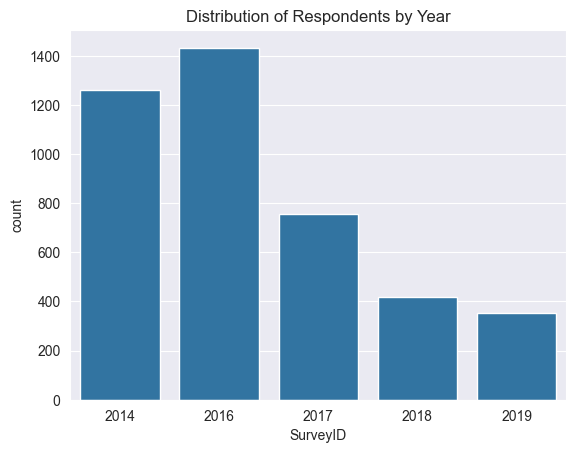

In [174]:
sns.barplot(data=df['SurveyID'].value_counts()).set_title("Distribution of Respondents by Year")

There was a peak in Responses in 2016 with declining responses ever since. This will make our cohort comparisons a little tricky. We'll have to see to what extent we can compare these different cohorts

### What country is this predominantly from?

In [175]:
df.groupby(["DEM_continent","DEM_country"]).agg(count=("DEM_country", "size")).sort_values(by="count", ascending=False).head(20)

count
DEM_continent DEM_country                    
North America United States of America   1872
Europe        United Kingdom              300
North America Canada                      122
Europe        Germany                      90
              Netherlands                  70
Oceania       Australia                    50
Asia          India                        39
Europe        France                       34
South America Brazil                       30
Europe        Spain                        24
              Ireland                      23
              Sweden                       23
              Portugal                     22
              Switzerland                  21
Oceania       New Zealand                  16
Europe        Poland                       13
              Russia                       13
              Norway                       11
North America Mexico                       10
Europe        Finland                      10

The USA has the vast majority of survey respondents, this means we'll probably spend more time deep diving into the USA in our analysis as it's the most robust sub population. However we might be able to draw some continent level comparisons.

In [176]:
df.groupby(["DEM_continent","SurveyID"]).agg(count=("DEM_continent", "size")).sort_values(by='count', ascending=False)

count
DEM_continent SurveyID       
North America 2016        929
              2017        532
Europe        2016        414
North America 2018        325
              2019        220
Europe        2017        174
              2019         84
              2018         66
Oceania       2016         43
Asia          2017         24
              2016         23
              2019         22
South America 2016         18
              2019         17
Oceania       2017         16
Asia          2018         10
Africa        2019          5
Oceania       2018          5
Africa        2018          5
South America 2018          5
Africa        2017          4
              2016          4
South America 2017          3
Oceania       2019          2

Continent level comparisons between Europe and USA seem sensible however we'll still need to manage the response disparity across the years.

In [177]:
df.groupby(["DEM_country","SurveyID"]).agg(count=("DEM_country", "size")).sort_values(by='count', ascending=False).head(20)

count
DEM_country              SurveyID       
United States of America 2016        851
                         2017        503
                         2018        314
                         2019        204
United Kingdom           2016        183
Canada                   2016         74
United Kingdom           2017         66
Germany                  2016         58
Netherlands              2016         47
Australia                2016         34
United Kingdom           2019         31
Canada                   2017         26
Germany                  2017         22
Sweden                   2016         20
United Kingdom           2018         20
Portugal                 2019         18
Brazil                   2019         17
France                   2017         16
Ireland                  2016         15
Spain                    2017         15

For the deeper dives we'll take a closer look at the USA

### What is the age / gender / Ethnicity distribution of tech workers?

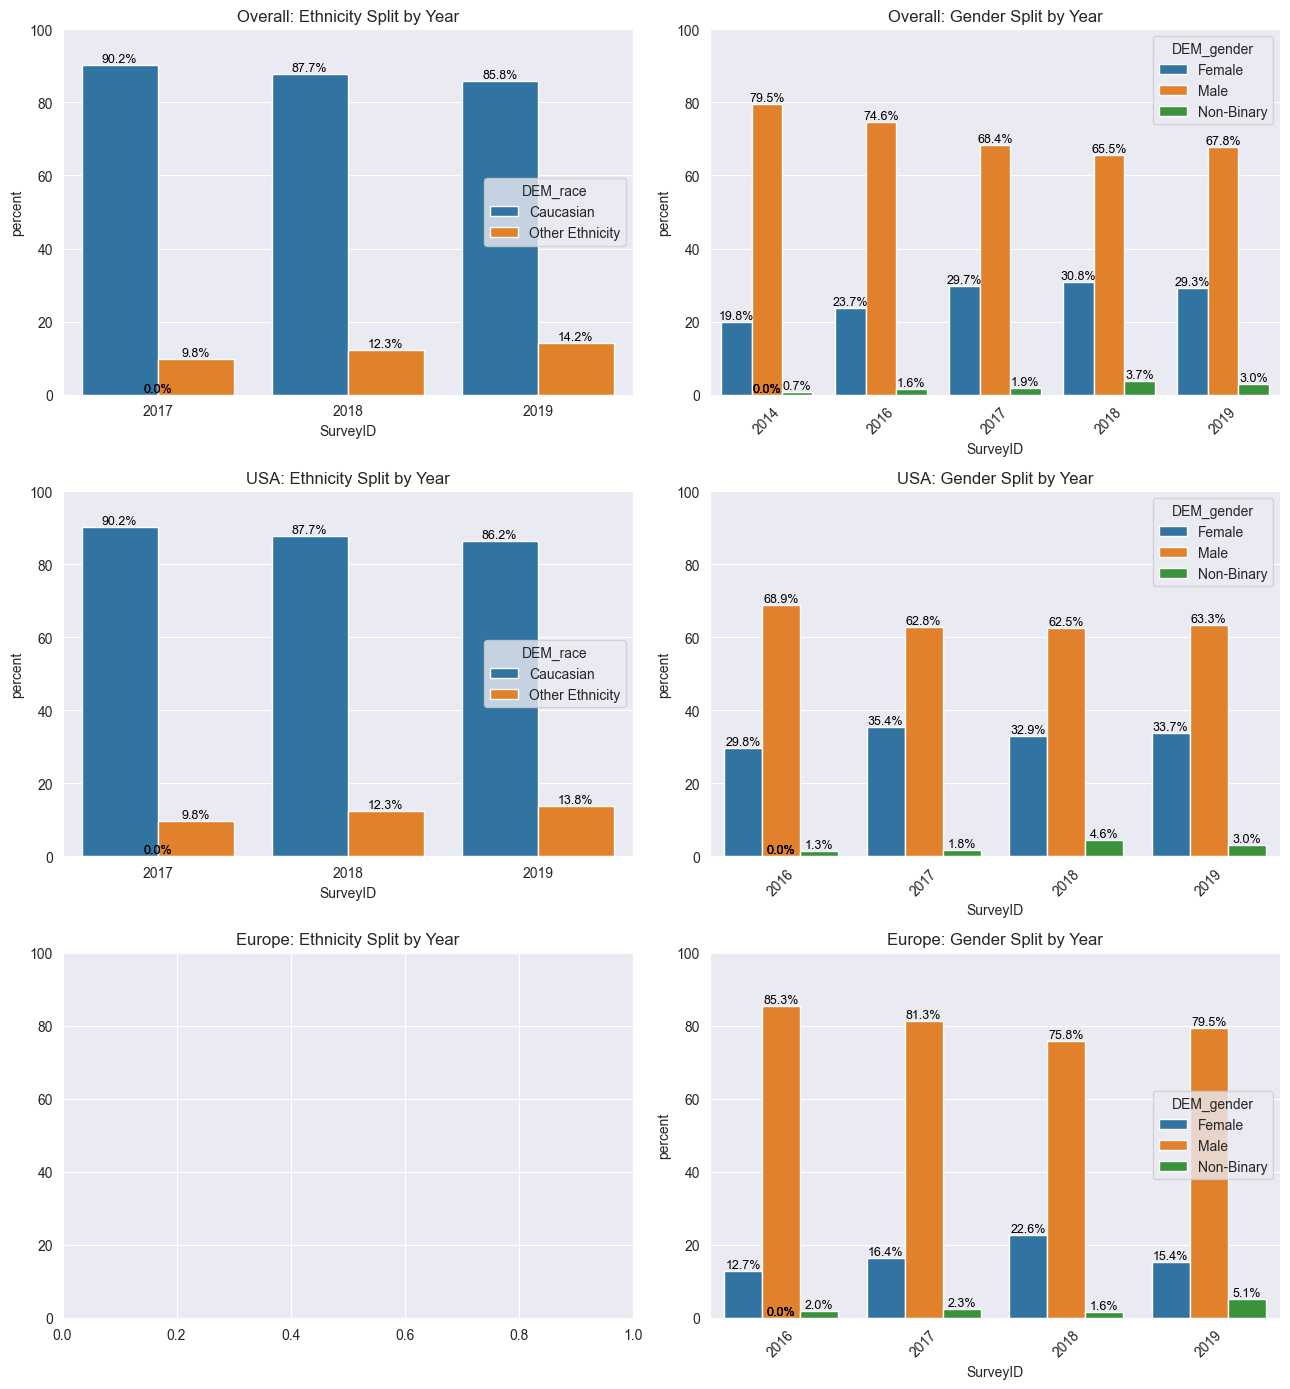

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(13, 14))

# --- Chart 1: Overall Ethnicity ---
subset1 = df.groupby(["SurveyID","DEM_race"]).agg(count=("DEM_race", "size")).reset_index()
subset1["percent"] = (subset1["count"] / subset1.groupby("SurveyID")["count"].transform("sum") * 100)
g = sns.barplot(data=subset1, x='SurveyID', y='percent', hue='DEM_race', ax=ax[0,0])
ax[0,0].set_title("Overall: Ethnicity Split by Year")
ax[0,0].set_ylim(0,100)
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=9, color='black')

# --- Chart 2: Overall Gender ---
subset2 = df.groupby(["SurveyID","DEM_gender"]).agg(count=("DEM_gender", "size")).reset_index()
subset2["percent"] = (subset2["count"] / subset2.groupby("SurveyID")["count"].transform("sum") * 100)
g = sns.barplot(data=subset2, x='SurveyID', y='percent', hue='DEM_gender', ax=ax[0,1])
ax[0,1].set_title("Overall: Gender Split by Year")
ax[0,1].tick_params(axis="x", rotation=45)
ax[0,1].set_ylim(0,100)
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=9, color='black')

# --- Chart 3: USA Ethnicity ---
subset1 = df[df['DEM_country']=='United States of America']
subset1 = subset1.groupby(["SurveyID","DEM_race"]).agg(count=("DEM_race", "size")).reset_index()
subset1["percent"] = (subset1["count"] / subset1.groupby("SurveyID")["count"].transform("sum") * 100)
g = sns.barplot(data=subset1, x='SurveyID', y='percent', hue='DEM_race', ax=ax[1,0])
ax[1,0].set_title("USA: Ethnicity Split by Year")
ax[1,0].set_ylim(0,100)
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=9, color='black')

# --- Chart 4: USA Gender ---
subset2 = df[df['DEM_country']=='United States of America']
subset2 = subset2.groupby(["SurveyID","DEM_gender"]).agg(count=("DEM_gender", "size")).reset_index()
subset2["percent"] = (subset2["count"] / subset2.groupby("SurveyID")["count"].transform("sum") * 100)
g = sns.barplot(data=subset2, x='SurveyID', y='percent', hue='DEM_gender', ax=ax[1,1])
ax[1,1].set_title("USA: Gender Split by Year")
ax[1,1].tick_params(axis="x", rotation=45)
ax[1,1].set_ylim(0,100)
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=9, color='black')

# --- Chart 5: Europe Ethnicity ---
subset1 = df[df['DEM_continent']=='Europe']
subset1 = subset1.groupby(["SurveyID","DEM_race"]).agg(count=("DEM_race", "size")).reset_index()
subset1["percent"] = (subset1["count"] / subset1.groupby("SurveyID")["count"].transform("sum") * 100)
g = sns.barplot(data=subset1, x='SurveyID', y='percent', hue='DEM_race', ax=ax[2,0])
ax[2,0].set_title("Europe: Ethnicity Split by Year")
ax[2,0].set_ylim(0,100)
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=9, color='black')

# --- Chart 6: Europe Gender ---
subset2 = df[df['DEM_continent']=='Europe']
subset2 = subset2.groupby(["SurveyID","DEM_gender"]).agg(count=("DEM_gender", "size")).reset_index()
subset2["percent"] = (subset2["count"] / subset2.groupby("SurveyID")["count"].transform("sum") * 100)
g = sns.barplot(data=subset2, x='SurveyID', y='percent', hue='DEM_gender', ax=ax[2,1])
ax[2,1].set_title("Europe: Gender Split by Year")
ax[2,1].tick_params(axis="x", rotation=45)
ax[2,1].set_ylim(0,100)
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


Overall, the gender split in the tech workforce has improved between 2016 and 2019. The most notable shift occurred in Europe, where the male-dominated share fell from 84% in 2016 to 74% in 2019. In comparison, the USA began from a lower baseline, moving from 68% to 62% male over the same period.

A similar trend can be seen in the inclusion of non-Caucasian ethnicities in the tech workforce, which also showed progress between 2016 and 2019.

In [179]:
df.groupby(["SurveyID","DEM_race"]).agg(count=("DEM_race", "size"),mean_age=("DEM_age","mean")).reset_index()

,SurveyID,DEM_race,count,mean_age
0,2017,Caucasian,435,35.742529
1,2017,Other Ethnicity,47,34.361702
2,2018,Caucasian,265,35.554717
3,2018,Other Ethnicity,37,31.810811
4,2019,Caucasian,175,36.218391
5,2019,Other Ethnicity,29,32.275862


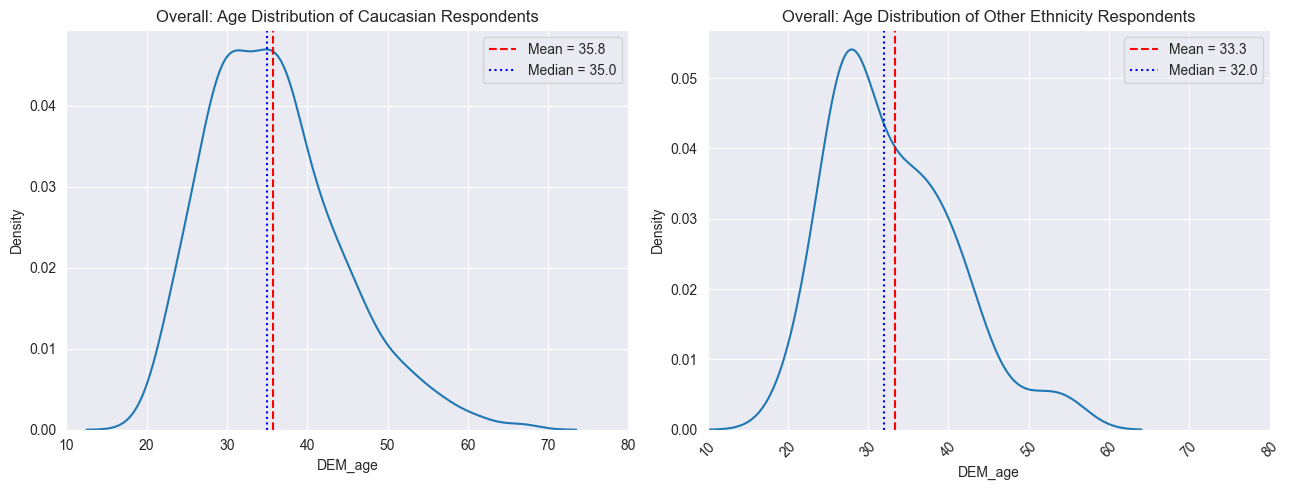

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# --- Chart 1: Caucasian only ---
subset1 = df[df['DEM_race'] == 'Caucasian']
sns.kdeplot(data=subset1, x='DEM_age', hue='DEM_race', ax=ax[0])
ax[0].set_title("Overall: Age Distribution of Caucasian Respondents")

# Add mean & median lines
mean1 = subset1['DEM_age'].mean()
median1 = subset1['DEM_age'].median()
ax[0].axvline(mean1, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean1:.1f}")
ax[0].axvline(median1, color='blue', linestyle=':', linewidth=1.5, label=f"Median = {median1:.1f}")
ax[0].legend()
ax[0].set_xlim(10,80)

# --- Chart 2: Non-Caucasian ---
subset2 = df[df['DEM_race'] != 'Caucasian']
sns.kdeplot(data=subset2, x='DEM_age', hue='DEM_race', ax=ax[1])
ax[1].set_title("Overall: Age Distribution of Other Ethnicity Respondents")
ax[1].tick_params(axis="x", rotation=45)

# Add mean & median lines
mean2 = subset2['DEM_age'].mean()
median2 = subset2['DEM_age'].median()
ax[1].axvline(mean2, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean2:.1f}")
ax[1].axvline(median2, color='blue', linestyle=':', linewidth=1.5, label=f"Median = {median2:.1f}")
ax[1].legend()
ax[1].set_xlim(10,80)

plt.tight_layout()
plt.show()


Overall, the majority of tech workers fall between the ages of 25 and 40. For non-Caucasian ethnicities, the age distribution is more right-skewed, with younger workers on average (33 years old compared to 36 years old for Caucasians). This trend may be explained by a higher proportion of younger entrants into the tech workforce, as reflected in the increased ethnic diversity observed in the earlier demographic bar charts.

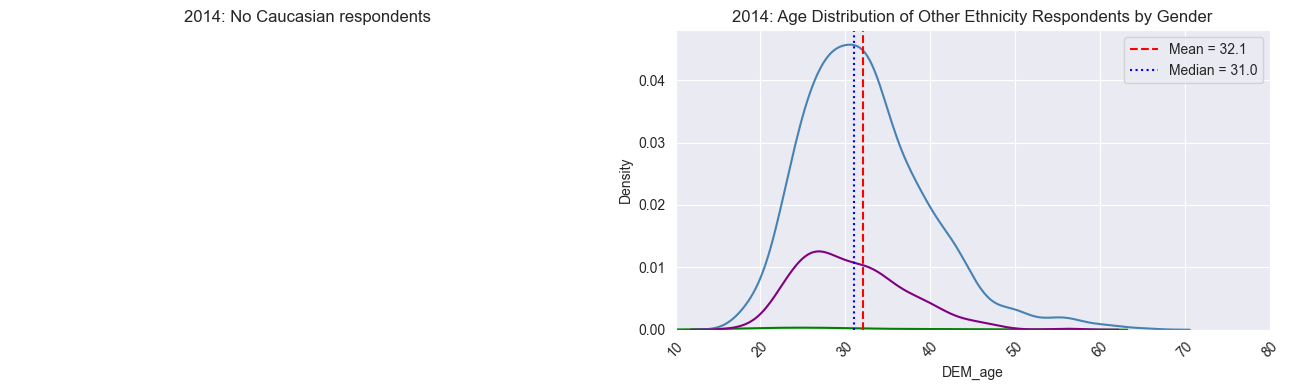

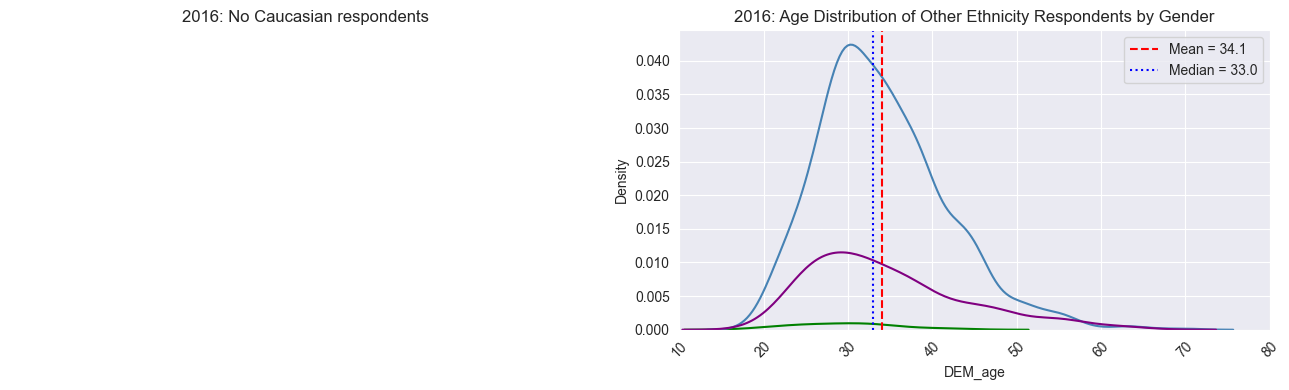

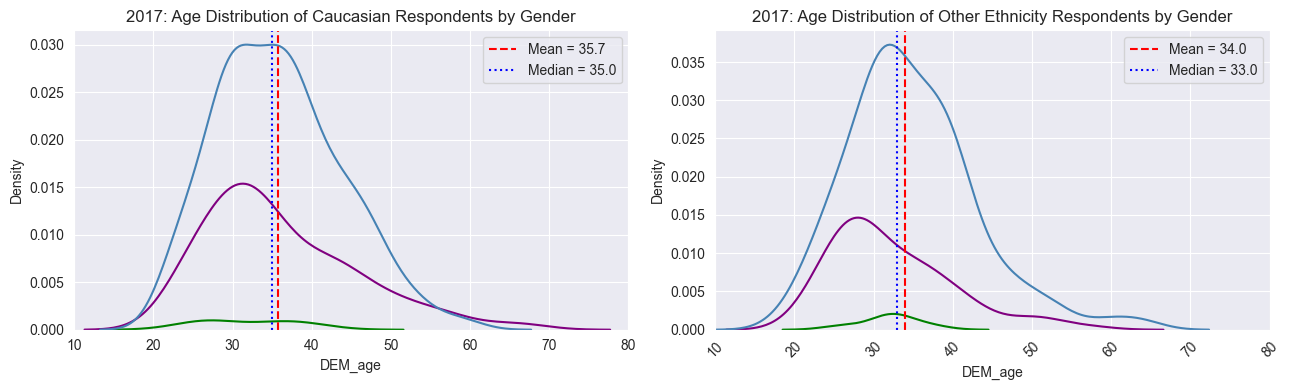

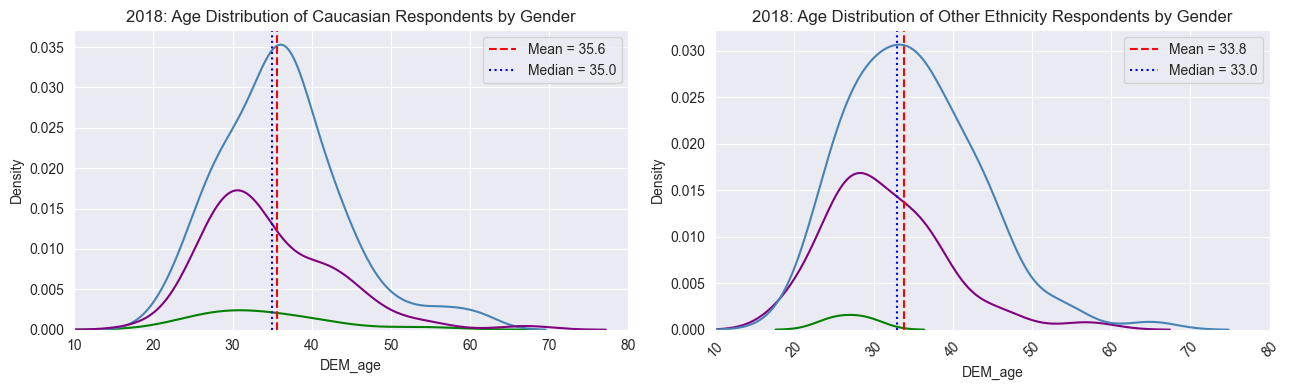

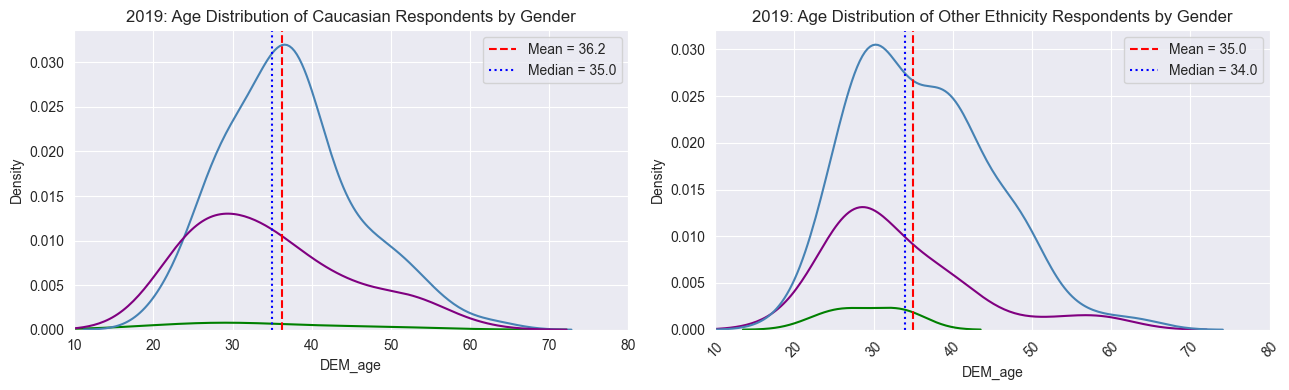

In [181]:
gender_palette = {
    "Male": "steelblue",
    "Female": "purple",
    "Non-Binary": "green",   # optional if present
    "Other": "grey"
}

survey_years = sorted(list(df.SurveyID.unique()))

for y in survey_years:
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    # --- Chart 1: Caucasian only ---
    subset1 = df[(df['DEM_race'] == 'Caucasian') & (df['SurveyID'] == y)]
    if not subset1.empty:
        sns.kdeplot(data=subset1, x='DEM_age', hue='DEM_gender', ax=ax[0], palette=gender_palette)
        ax[0].set_title(f"{y}: Age Distribution of Caucasian Respondents by Gender")

        mean1 = subset1['DEM_age'].mean()
        median1 = subset1['DEM_age'].median()
        ax[0].axvline(mean1, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean1:.1f}")
        ax[0].axvline(median1, color='blue', linestyle=':', linewidth=1.5, label=f"Median = {median1:.1f}")
        ax[0].legend()
        ax[0].set_xlim(10,80)
    else:
        ax[0].set_title(f"{y}: No Caucasian respondents")
        ax[0].axis("off")

    # --- Chart 2: Non-Caucasian ---
    subset2 = df[(df['DEM_race'] != 'Caucasian') & (df['SurveyID'] == y)]
    if not subset2.empty:
        sns.kdeplot(data=subset2, x='DEM_age', hue='DEM_gender', ax=ax[1], palette=gender_palette)
        ax[1].set_title(f"{y}: Age Distribution of Other Ethnicity Respondents by Gender")
        ax[1].tick_params(axis="x", rotation=45)

        mean2 = subset2['DEM_age'].mean()
        median2 = subset2['DEM_age'].median()
        ax[1].axvline(mean2, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean2:.1f}")
        ax[1].axvline(median2, color='blue', linestyle=':', linewidth=1.5, label=f"Median = {median2:.1f}")
        ax[1].legend()
        ax[1].set_xlim(10,80)
    else:
        ax[1].set_title(f"{y}: No Non-Caucasian respondents")
        ax[1].axis("off")

    plt.tight_layout()
    plt.show()


Similar to our earlier charts, we can hypothesize that the younger age distribution among females (pink line) is driven by an increase in new entrants to the workforce. This is particularly evident between 2017 and 2019, where the median female age across all ethnicities peaks around 28—significantly younger compared to Caucasian men, whose median age is approximately 37.

### What's the distribution of Jobs by age? Gender?

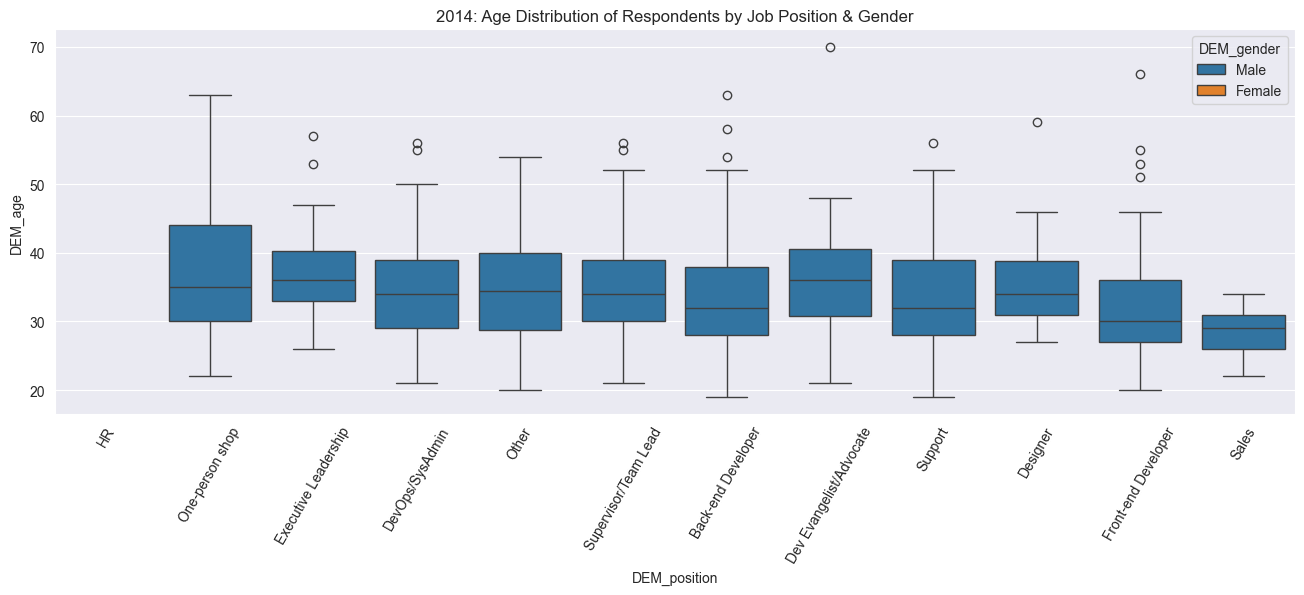

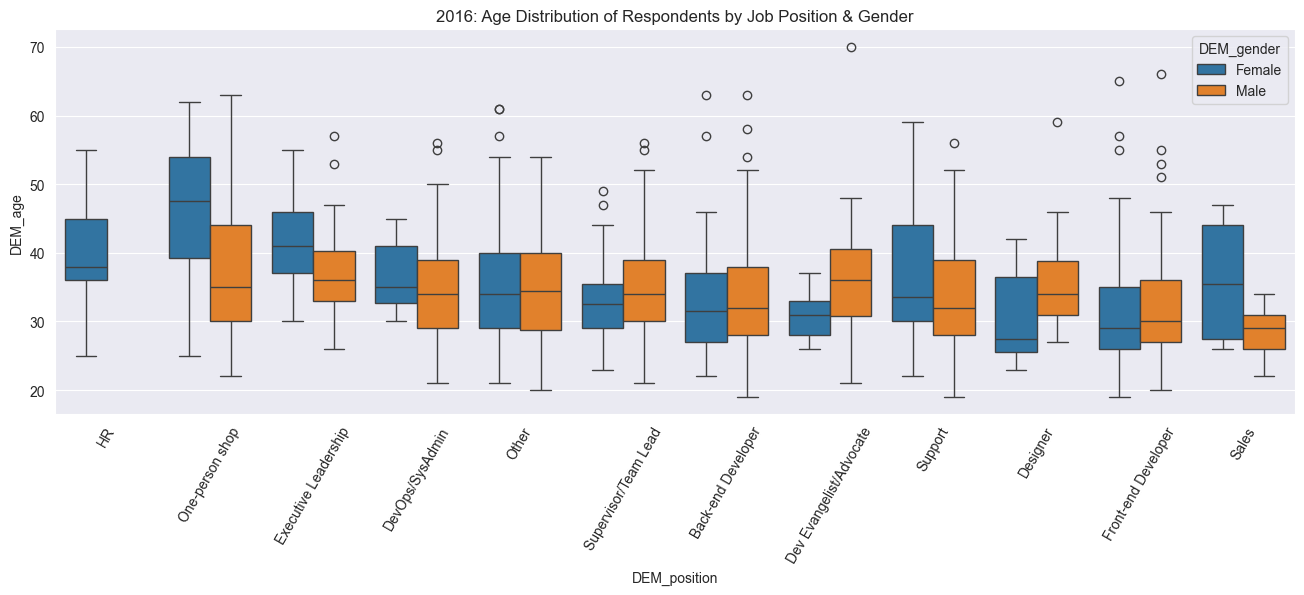

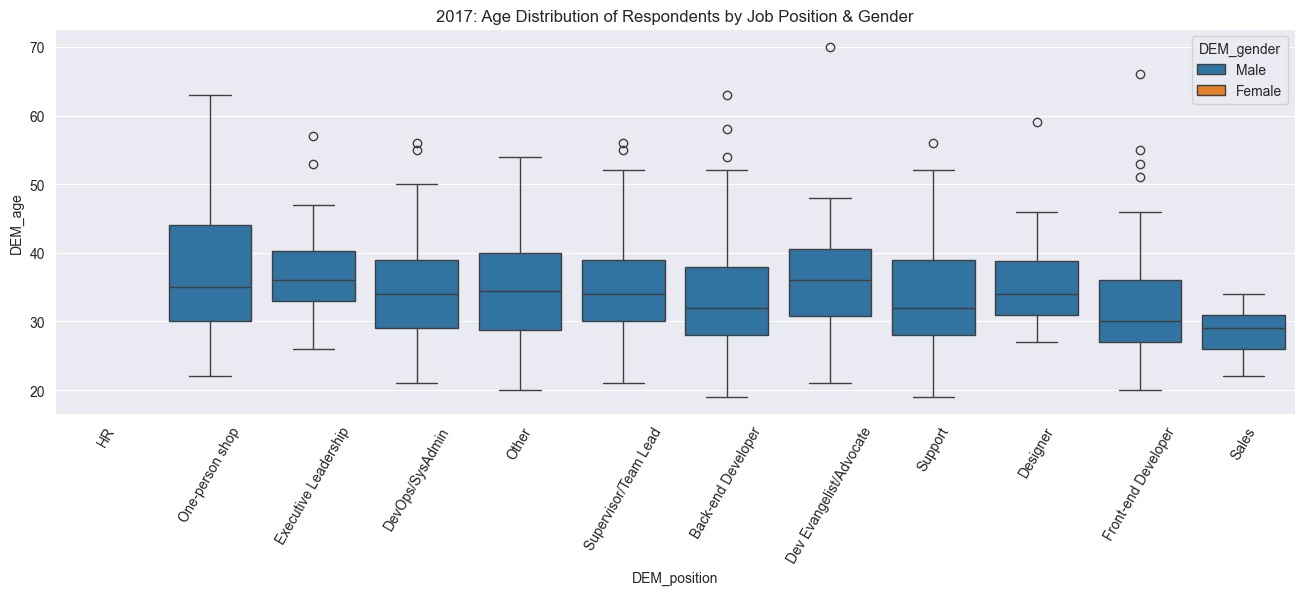

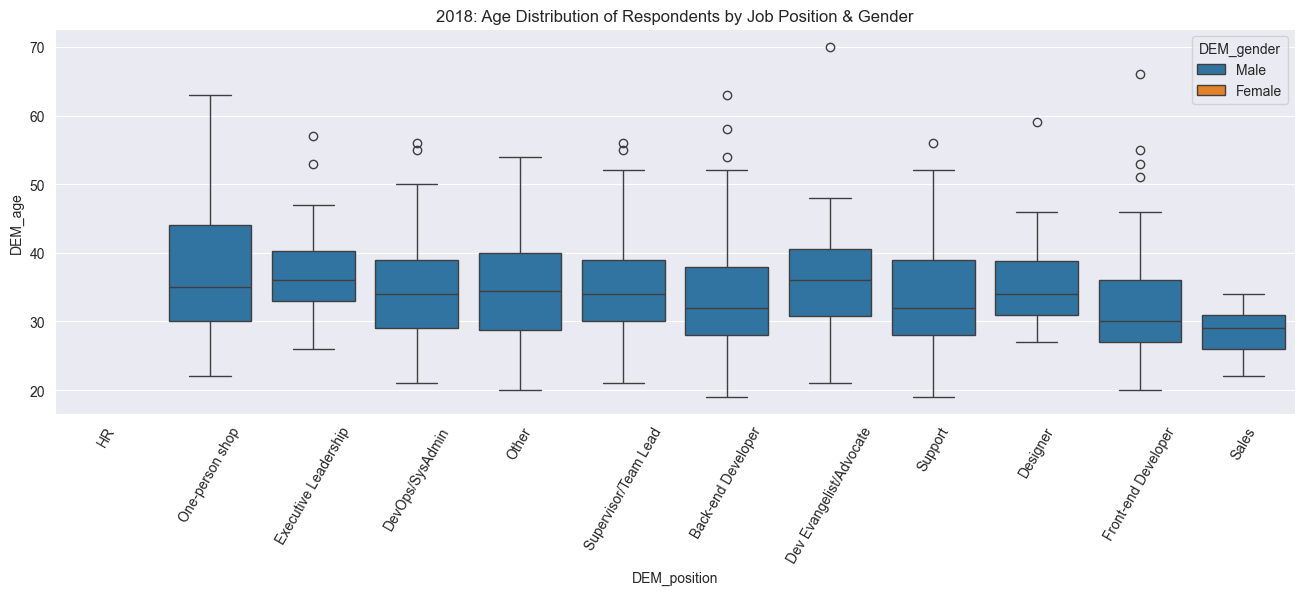

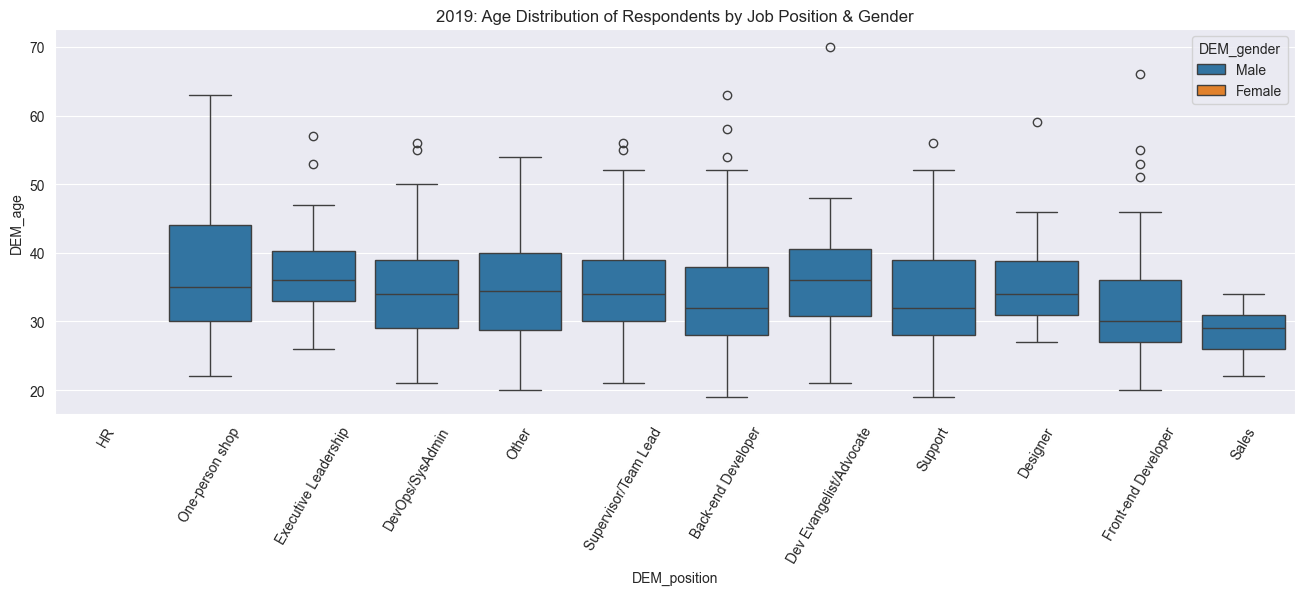

In [182]:

survey_years = sorted(list(df.SurveyID.unique()))

for y in survey_years:
    temp_df = df[(df['DEM_gender']=='Male') | (df['DEM_gender']=='Female') & (df['SurveyID']==y)]

    # Calculate median age per position
    order = (
    df.groupby("DEM_position")["DEM_age"]
      .median()
      .sort_values(ascending=False)
      .index)

    plt.figure(figsize=(16, 5))
    ax = sns.boxplot(data=temp_df, x="DEM_position", y="DEM_age", order=order, hue='DEM_gender')
    ax.tick_params(axis="x", rotation=60)
    ax.set_title(f"{y}: Age Distribution of Respondents by Job Position & Gender")

In [183]:
df.groupby(["DEM_remote","SurveyID"]).agg(count=("DEM_remote", "size")).sort_values(by="count", ascending=False)

,,count
DEM_remote,SurveyID,
Sometimes,2016,757
Always,2016,343
Never,2016,333


## Tech Workers - Personal Mental Health Views


In [184]:
df.head()

,SurveyID,UserID,DEM_age,DEM_gender,DEM_country,DEM_continent,DEM_race,DEM_remote_50plus,DEM_remote,DEM_position,PMH_current_mh_disorder,PMH_diagnosed_mh_disorder,PMH_mh_disorder_interference_treated,PMH_mh_affects_productivity,PMH_mh_affects_work_pct,PMH_openly_identified_mh,PMH_mh_identification_career_effect,PMH_mh_condition_interference,DMH_comfortable_mh_coworkers,DMH_comfortable_mh_supervisor,DMH_willing_mh_supervisor_past,DMH_willing_share_friends_family,DMH_discussed_mh_employer,DMH_discussed_mh_prev_employer,DMH_mh_mention_in_interview,SUP_unsupportive_response_observed,SUP_employer_importance_physical,SUP_employer_importance_mental,SUP_prev_employer_importance_physical,SUP_prev_employer_importance_mental,SUP_industry_support_mh,SUP_employer_seriousness_mh_vs_physical,SUP_employer_provides_resources,STIG_observations_reduce_disclosure,STIG_neg_conseq_physical_employer,STIG_neg_conseq_mh_employer,STIG_neg_conseq_mh_disorder_employer,STIG_observed_neg_conseq_coworkers,STIG_neg_conseq_coworker_prev_workplace,willing_physical_employer_interview
0,2016,1279,25,Female,United States of America,North America,None,None,Always,One-person shop,Yes,Yes,Often,Yes,76-100%,None,None,NaN,None,None,None,Somewhat not open,None,None,None,"Yes, I observed",<NA>,<NA>,<NA>,<NA>,<NA>,None,None,Yes,NaN,None,NaN,None,None,No
1,2016,1285,38,Male,United States of America,North America,None,None,Sometimes,Supervisor/Team Lead,No,No,Not applicable to me,Not applicable to me,NaN,None,None,NaN,None,None,Some of my previous employers,Not applicable to me,None,None,None,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,None,None,NaN,NaN,None,NaN,None,Some of them,Maybe
2,2016,1333,46,Male,United States of America,North America,None,None,Sometimes,Supervisor/Team Lead,No,No,Not applicable to me,None,NaN,None,None,NaN,No,No,"No, at none of my previous employers",Not open at all,None,None,None,No,<NA>,<NA>,<NA>,<NA>,<NA>,No,None,NaN,Maybe,None,Yes,No,None of them,No
3,2016,1346,45,Male,United States of America,North America,None,None,Never,Front-end Developer,Maybe,No,Not applicable to me,None,NaN,None,None,NaN,No,Maybe,"No, at none of my previous employers",Somewhat not open,None,None,None,"Yes, I experienced",<NA>,<NA>,<NA>,<NA>,<NA>,No,None,NaN,No,None,Maybe,No,None of them,Maybe
4,2016,1353,26,Male,United Kingdom,Europe,None,None,Sometimes,Supervisor/Team Lead,Yes,No,Rarely,None,NaN,None,None,NaN,Maybe,Yes,"No, at none of my previous employers",Somewhat open,None,None,None,Maybe/Not sure,<NA>,<NA>,<NA>,<NA>,<NA>,Yes,None,No,No,None,No,No,None of them,Yes


[Text(0.5, 0, 'Ever Been Diagnosed with MH Disorder'),
 Text(0, 0.5, '% of Respondents')]

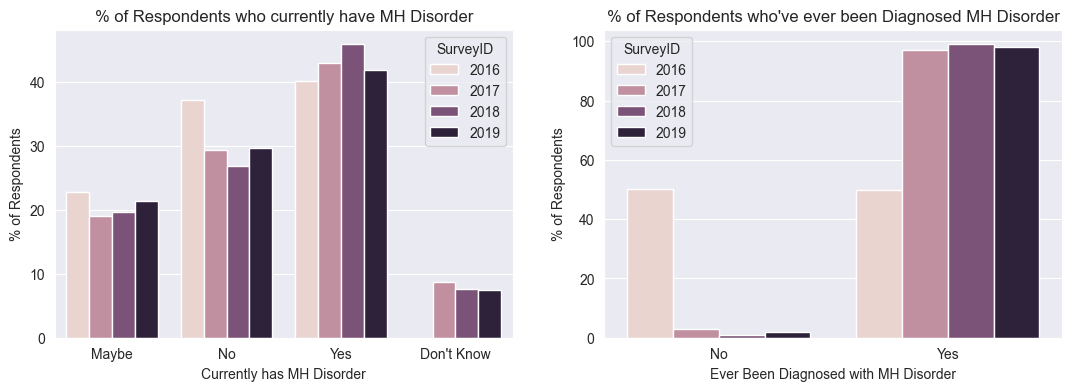

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.barplot(data=hf.df_col_pct_grouped(df,"SurveyID","PMH_current_mh_disorder"),x='PMH_current_mh_disorder',y='PMH_current_mh_disorder_pct', hue='SurveyID', ax=ax[0])
ax[0].set_title("% of Respondents who currently have MH Disorder")
ax[0].set(xlabel='Currently has MH Disorder', ylabel='% of Respondents')

sns.barplot(data=hf.df_col_pct_grouped(df,"SurveyID","PMH_diagnosed_mh_disorder"),x='PMH_diagnosed_mh_disorder',y='PMH_diagnosed_mh_disorder_pct', hue='SurveyID', ax=ax[1])
ax[1].set_title("% of Respondents who've ever been Diagnosed MH Disorder")
ax[1].set(xlabel='Ever Been Diagnosed with MH Disorder', ylabel='% of Respondents')

These charts examine whether respondents:

(Left) Currently have a mental health disorder

(Right) Have ever been diagnosed with a mental health disorder

What’s striking is that nearly all respondents report having been diagnosed with a mental health disorder at some point in their lives. This seems highly improbable and raises questions about data integrity—especially given that only about 42% state they currently have some form of mental health disorder.

This discrepancy could stem from self-diagnosis, misinterpretation of the question, or issues in data collection. To clarify, we should review the absolute numbers to check whether the results are being skewed by sparse data.

In [186]:
hf.df_col_pct_grouped(df,"SurveyID","PMH_diagnosed_mh_disorder")

,SurveyID,PMH_diagnosed_mh_disorder,count,PMH_diagnosed_mh_disorder_pct
0,2016,No,717,50.03
1,2016,Yes,716,49.97
2,2017,No,10,3.09
3,2017,Yes,314,96.91
4,2018,No,2,1.05
5,2018,Yes,189,98.95
6,2019,No,3,2.04
7,2019,Yes,144,97.96


In [187]:
df_usa = df[df['DEM_country'] == 'United States of America']
df_other = df[df['DEM_country'] != 'United States of America']

df_usa.groupby(['DEM_country','SurveyID', 'PMH_diagnosed_mh_disorder']).agg(count=('PMH_diagnosed_mh_disorder', "size")).reset_index().sort_values(by='count', ascending=False)

,DEM_country,SurveyID,PMH_diagnosed_mh_disorder,count
1,United States of America,2016,Yes,476
0,United States of America,2016,No,375
3,United States of America,2017,Yes,244
5,United States of America,2018,Yes,160
7,United States of America,2019,Yes,105
2,United States of America,2017,No,4
4,United States of America,2018,No,2
6,United States of America,2019,No,1


These volumes as a proportion of our sample data don't suggest we're under counting. In any case this data seems questionable at best but can assume around 42% of tech workers may be at least affected by MH.

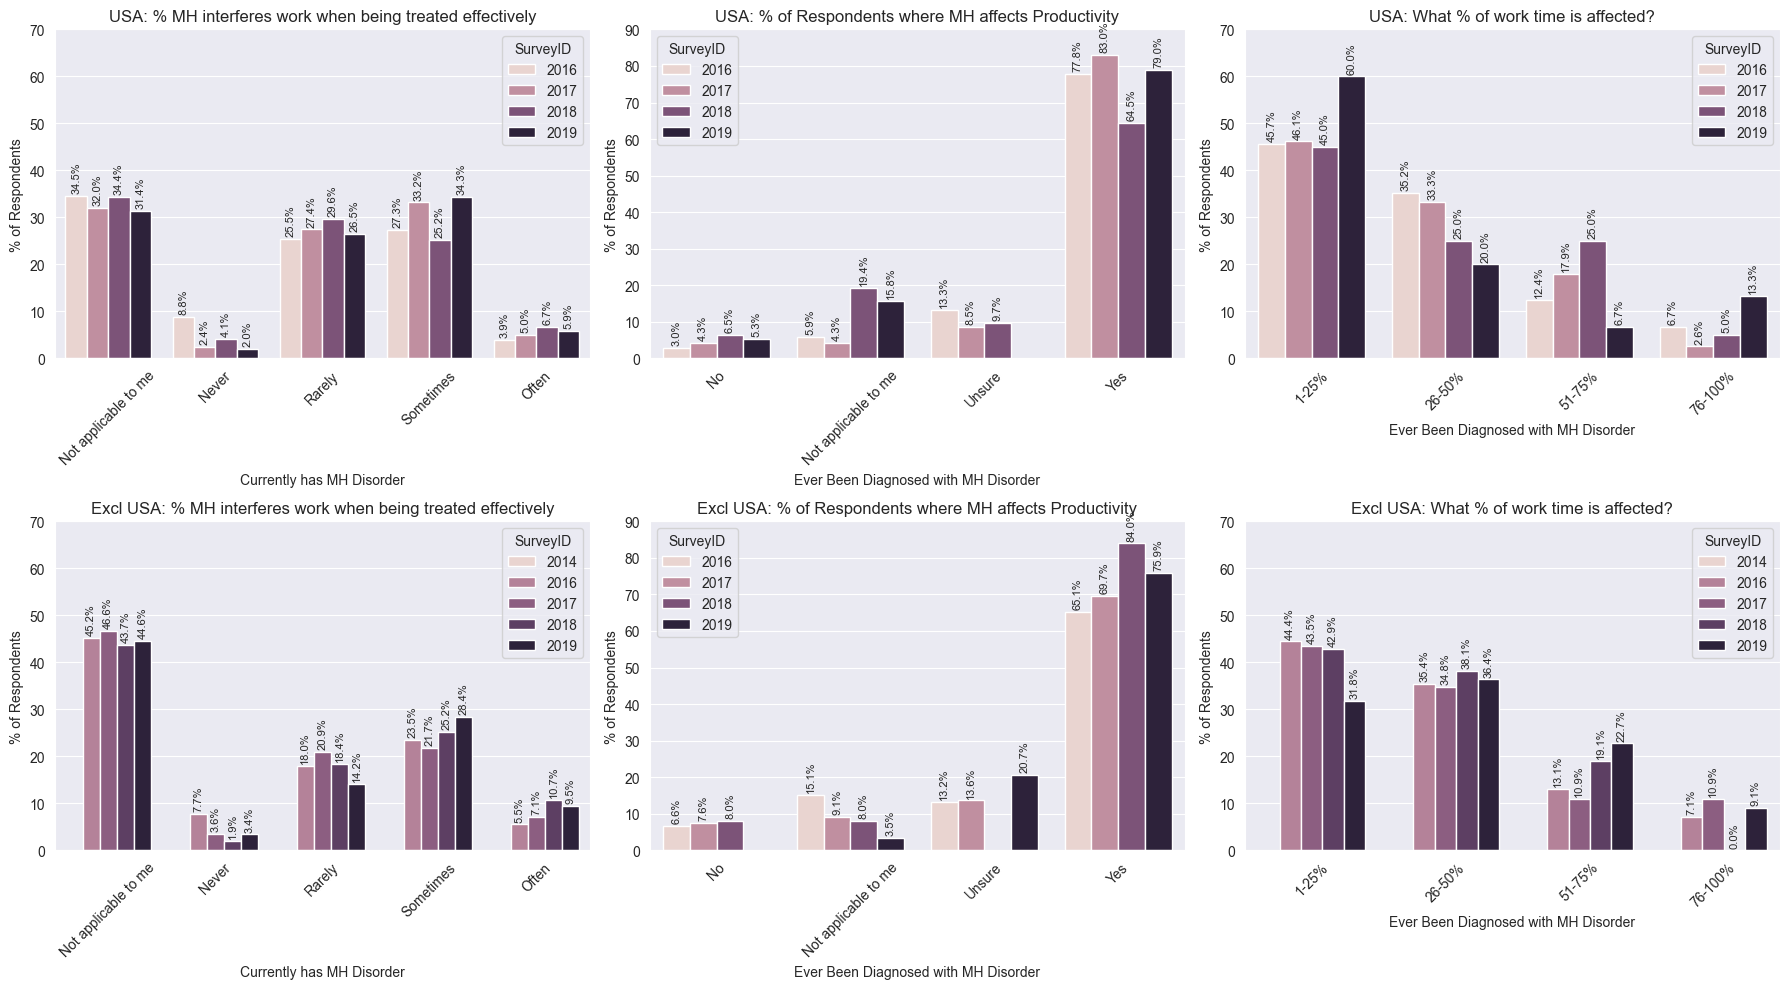

In [188]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

sns.barplot(data=hf.df_col_pct_grouped(df_usa,"SurveyID","PMH_mh_disorder_interference_treated"),x='PMH_mh_disorder_interference_treated',y='PMH_mh_disorder_interference_treated_pct', hue='SurveyID', ax=ax[0,0])
ax[0,0].set_title("USA: % MH interferes work when being treated effectively")
ax[0,0].set(xlabel='Currently has MH Disorder', ylabel='% of Respondents')
ax[0,0].tick_params(axis="x", rotation=45)
ax[0,0].set_ylim(0,70)

sns.barplot(data=hf.df_col_pct_grouped(df_usa,"SurveyID","PMH_mh_affects_productivity"),x='PMH_mh_affects_productivity',y='PMH_mh_affects_productivity_pct', hue='SurveyID', ax=ax[0,1])
ax[0,1].set_title("USA: % of Respondents where MH affects Productivity")
ax[0,1].set(xlabel='Ever Been Diagnosed with MH Disorder', ylabel='% of Respondents')
ax[0,1].tick_params(axis="x", rotation=45)
ax[0,1].set_ylim(0,90)


sns.barplot(data=hf.df_col_pct_grouped(df_usa,"SurveyID","PMH_mh_affects_work_pct"),x='PMH_mh_affects_work_pct',y='PMH_mh_affects_work_pct_pct', hue='SurveyID', ax=ax[0,2])
ax[0,2].set_title("USA: What % of work time is affected?")
ax[0,2].set(xlabel='Ever Been Diagnosed with MH Disorder', ylabel='% of Respondents')
ax[0,2].tick_params(axis="x", rotation=45)
ax[0,2].set_ylim(0,70)


# ROW 2
sns.barplot(data=hf.df_col_pct_grouped(df_other,"SurveyID","PMH_mh_disorder_interference_treated"),x='PMH_mh_disorder_interference_treated',y='PMH_mh_disorder_interference_treated_pct', hue='SurveyID', ax=ax[1,0])
ax[1,0].set_title("Excl USA: % MH interferes work when being treated effectively")
ax[1,0].set(xlabel='Currently has MH Disorder', ylabel='% of Respondents')
ax[1,0].tick_params(axis="x", rotation=45)
ax[1,0].set_ylim(0,70)

sns.barplot(data=hf.df_col_pct_grouped(df_other,"SurveyID","PMH_mh_affects_productivity"),x='PMH_mh_affects_productivity',y='PMH_mh_affects_productivity_pct', hue='SurveyID', ax=ax[1,1])
ax[1,1].set_title("Excl USA: % of Respondents where MH affects Productivity")
ax[1,1].set(xlabel='Ever Been Diagnosed with MH Disorder', ylabel='% of Respondents')
ax[1,1].tick_params(axis="x", rotation=45)
ax[1,1].set_ylim(0,90)


sns.barplot(data=hf.df_col_pct_grouped(df_other,"SurveyID","PMH_mh_affects_work_pct"),x='PMH_mh_affects_work_pct',y='PMH_mh_affects_work_pct_pct', hue='SurveyID', ax=ax[1,2])
ax[1,2].set_title("Excl USA: What % of work time is affected?")
ax[1,2].set(xlabel='Ever Been Diagnosed with MH Disorder', ylabel='% of Respondents')
ax[1,2].tick_params(axis="x", rotation=45)
ax[1,2].set_ylim(0,70)


plt.tight_layout(h_pad=1.0)

# --- Add labels for all 3 charts
for axes in [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]:
    for container in axes.containers:
        axes.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=8, rotation=90, padding=2)

There doesn’t appear to be a clear trend over time showing whether mental health issues are increasingly or decreasingly affecting tech workers’ productivity. What these charts do show, however, is that mental health consistently has an impact to some degree.

Looking at the first chart on the left: even among workers receiving effective treatment, only about 5% report that mental health never affects their work. In fact, the combined share of respondents answering “Never” or “Rarely” is about the same as those answering “Sometimes” or “Often.”

The two charts in the centre and on the right further highlight that mental health issues undeniably affect productivity, with around 75% of respondents confirming some impact. Between 2014 and 2019, there does seem to be an upward trend in the proportion of time work is affected. However, given inconsistencies in the data, we’ll treat this as useful context rather than drawing any definitive conclusions.

## Comfort Discussing Mental Health

Going forward we'll concentrate on USA only as that's where we have the most robust data. However we will try to draw international comparisons where the data is roubust enough

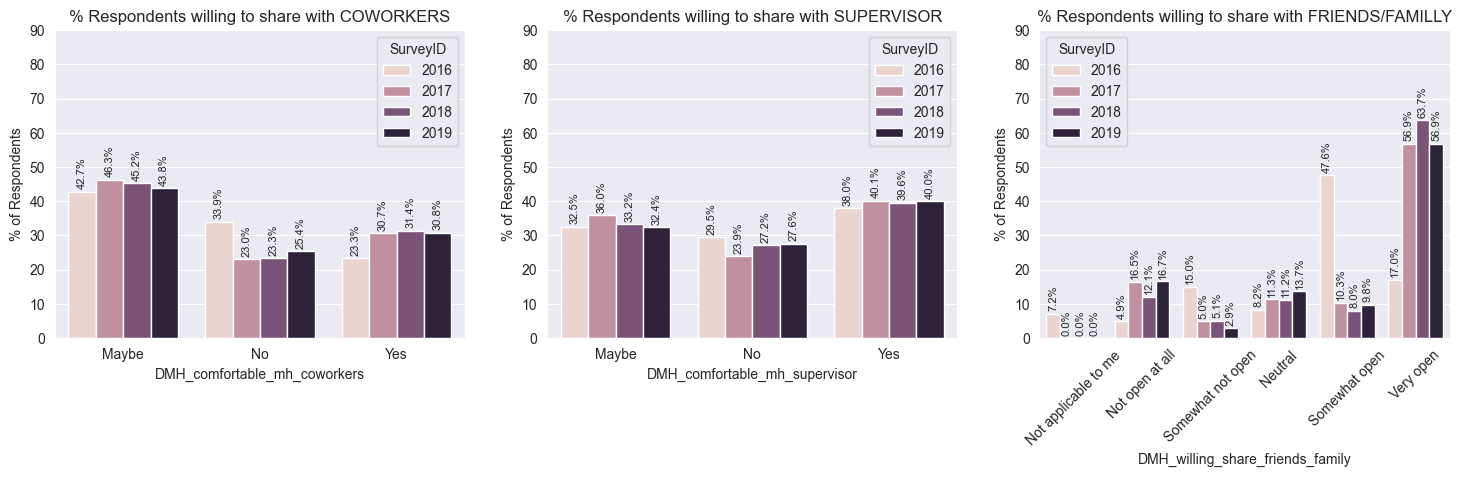

In [189]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(data=hf.df_col_pct_grouped(df_usa,"SurveyID","DMH_comfortable_mh_coworkers"),x='DMH_comfortable_mh_coworkers',y='DMH_comfortable_mh_coworkers_pct', hue='SurveyID', ax=ax[0])
ax[0].set_title("% Respondents willing to share with COWORKERS")
ax[0].set(ylabel='% of Respondents')
ax[0].set_ylim(0,90)

sns.barplot(data=hf.df_col_pct_grouped(df_usa,"SurveyID","DMH_comfortable_mh_supervisor"),x='DMH_comfortable_mh_supervisor',y='DMH_comfortable_mh_supervisor_pct', hue='SurveyID', ax=ax[1])
ax[1].set_title("% Respondents willing to share with SUPERVISOR")
ax[1].set(ylabel='% of Respondents')
ax[1].set_ylim(0,90)


sns.barplot(data=hf.df_col_pct_grouped(df_usa,"SurveyID","DMH_willing_share_friends_family"),x='DMH_willing_share_friends_family',y='DMH_willing_share_friends_family_pct', hue='SurveyID', ax=ax[2])
ax[2].set_title("% Respondents willing to share with FRIENDS/FAMILLY")
ax[2].set(ylabel='% of Respondents')
ax[2].tick_params(axis="x", rotation=45)
ax[2].set_ylim(0,90)


# --- Add labels for all 3 charts
for axes in [ax[0], ax[1], ax[2]]:
    for container in axes.containers:
        axes.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=8, rotation=90, padding=2)

Ignoring the outliers in 2016, openness to sharing mental health concerns appears to have remained very consistent. Tech workers are far more comfortable discussing these concerns with friends and family than within their work environment. So far, there are no indications that this pattern is likely to change.

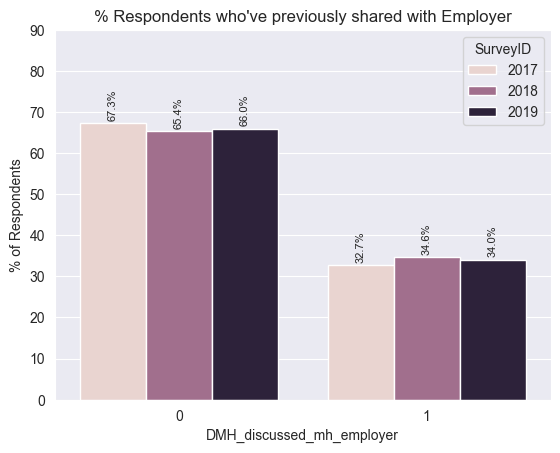

In [190]:
ax = sns.barplot(
    data=hf.df_col_pct_grouped(df_usa, "SurveyID", "DMH_discussed_mh_employer"),
    x='DMH_discussed_mh_employer',
    y='DMH_discussed_mh_employer_pct',
    hue='SurveyID'
)

ax.set_title("% Respondents who've previously shared with Employer")
ax.set(ylabel='% of Respondents')
ax.set_ylim(0, 90)

# Add data labels
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f%%",
        label_type="edge",   # "edge" = at bar edge, "center" = inside bar
        fontsize=8,
        rotation=90,
        padding=2
    )


Around 34% of US tech workers have previously raised mental health concerns with their employer.

This level of openness is consistent with our earlier charts, which showed a similar proportion of respondents willing to share such concerns with their employer.

## Stigma & Negative Consequences

In [191]:
df.groupby(["SurveyID","DEM_continent","STIG_neg_conseq_mh_disorder_employer"]).agg(count=("STIG_neg_conseq_mh_disorder_employer", "size")).sort_values(by="count", ascending=False).head(20)

count
SurveyID DEM_continent STIG_neg_conseq_mh_disorder_employer       
2016     North America Maybe                                   341
                       No                                      287
                       Yes                                     151
         Europe        No                                      127
                       Maybe                                   119
                       Yes                                      51
         Oceania       No                                       12
                       Maybe                                    11
                       Yes                                       9
         South America Maybe                                     8
         Asia          Maybe                                     8
                       No                                        6
         South America Yes                                       5
                       No                                        3
         Asia          Yes                                       3
         Africa        No                                        2
                       Yes                                       2
2018     Europe        Yes                                       0
         Africa        Yes                                       0
         Asia          No                                        0

We want to dig deeper into Employees perceptions of negative treatment when disclosing MH issues. As this question was only asked in 2016 we'll be consistent and only associate these findings with other 2016 dated responses

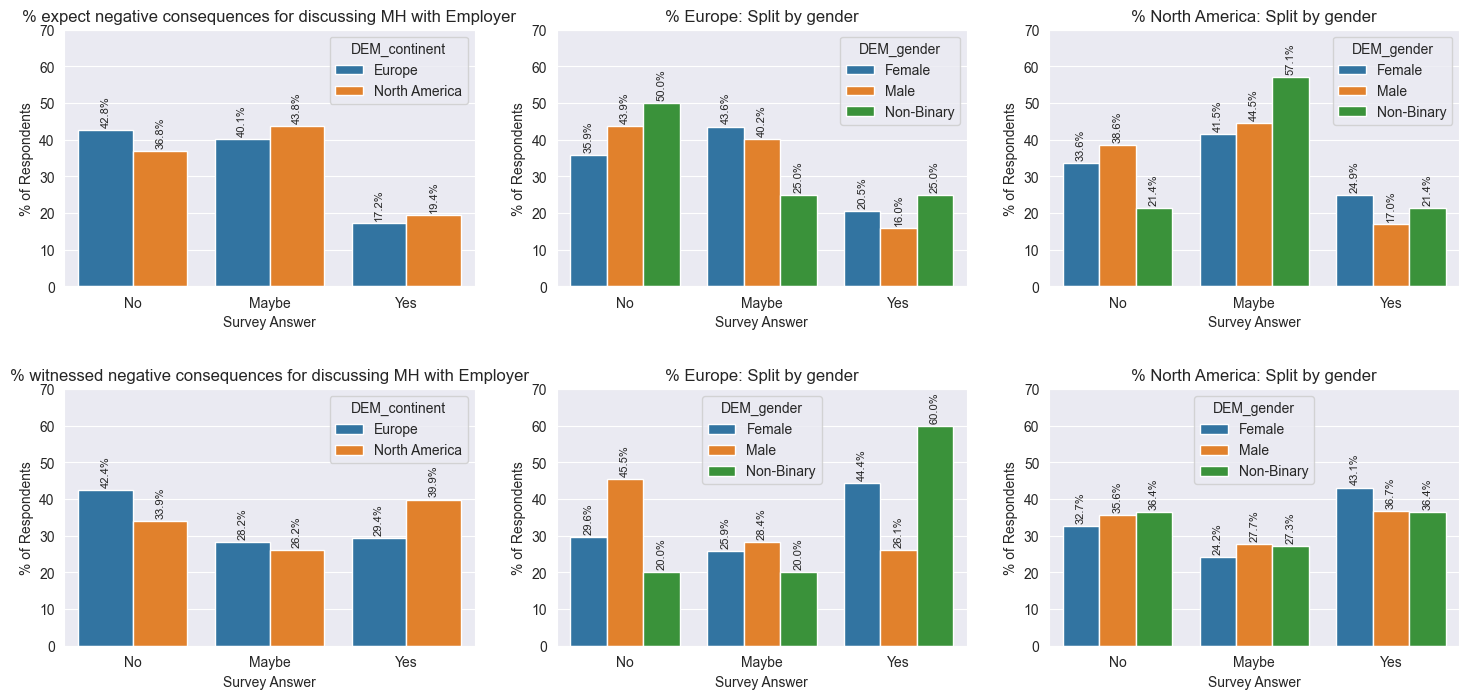

In [192]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

df_2016 = df[df['SurveyID']==2016]

# Chart 1
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe','North America'])], "DEM_continent", "STIG_neg_conseq_mh_disorder_employer"),
    x='STIG_neg_conseq_mh_disorder_employer',
    y='STIG_neg_conseq_mh_disorder_employer_pct',
    hue='DEM_continent',
    ax=ax[0,0]
)

ax[0,0].set_title("% expect negative consequences for discussing MH with Employer")
#ax[0].set_ylim(0, 30)


# Chart 2
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe'])], "DEM_gender", "STIG_neg_conseq_mh_disorder_employer"),
    x='STIG_neg_conseq_mh_disorder_employer',
    y='STIG_neg_conseq_mh_disorder_employer_pct',
    hue='DEM_gender',
    ax=ax[0,1]
)

ax[0,1].set_title("% Europe: Split by gender")
#ax[1].set_ylim(0, 30)


sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['North America'])], "DEM_gender", "STIG_neg_conseq_mh_disorder_employer"),
    x='STIG_neg_conseq_mh_disorder_employer',
    y='STIG_neg_conseq_mh_disorder_employer_pct',
    hue='DEM_gender',
    ax=ax[0,2]
)

ax[0,2].set_title("% North America: Split by gender")
#ax[2].set_ylim(0, 30)



# Chart 1
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe','North America'])], "DEM_continent", "STIG_observations_reduce_disclosure"),
    x='STIG_observations_reduce_disclosure',
    y='STIG_observations_reduce_disclosure_pct',
    hue='DEM_continent',
    ax=ax[1,0]
)

ax[1,0].set_title("% witnessed negative consequences for discussing MH with Employer")
#ax[0].set_ylim(0, 30)


# Chart 2
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe'])], "DEM_gender", "STIG_observations_reduce_disclosure"),
    x='STIG_observations_reduce_disclosure',
    y='STIG_observations_reduce_disclosure_pct',
    hue='DEM_gender',
    ax=ax[1,1]
)

ax[1,1].set_title("% Europe: Split by gender")
#ax[1].set_ylim(0, 30)


sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['North America'])], "DEM_gender", "STIG_observations_reduce_disclosure"),
    x='STIG_observations_reduce_disclosure',
    y='STIG_observations_reduce_disclosure_pct',
    hue='DEM_gender',
    ax=ax[1,2]
)

ax[1,2].set_title("% North America: Split by gender")
#ax[2].set_ylim(0, 30)


# --- Add labels for all 3 charts
for axes in [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]:
    for container in axes.containers:
        axes.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=8, rotation=90, padding=2)
        axes.set(ylabel='% of Respondents', xlabel='Survey Answer')
        axes.set_ylim(0, 70)

plt.subplots_adjust(hspace=0.4)



In the previous sections, we explored tech workers’ openness to discussing mental health issues with friends, family, and colleagues. Here, we shift focus to whether their reluctance to share concerns with colleagues or supervisors is justified—specifically, whether disclosing these concerns leads to negative outcomes.

The first row of charts shows the percentage of respondents, broken down by geography and gender, who were asked whether they expected negative consequences from discussing mental health with their employer:
- Roughly 40% did not expect any negative consequences.
- Around 20% expected negative consequences.
- Approximately 40% were uncertain, responding “Maybe.”

The second row looks at whether respondents had actually witnessed negative consequences:
- Up to 40% of tech workers in North America reported witnessing negative consequences, compared to 30% in Europe—around double the rates of those who initially expected them.
- A slight gender disparity emerges, with females reporting higher rates of witnessing negative consequences than males in both Europe and North America.


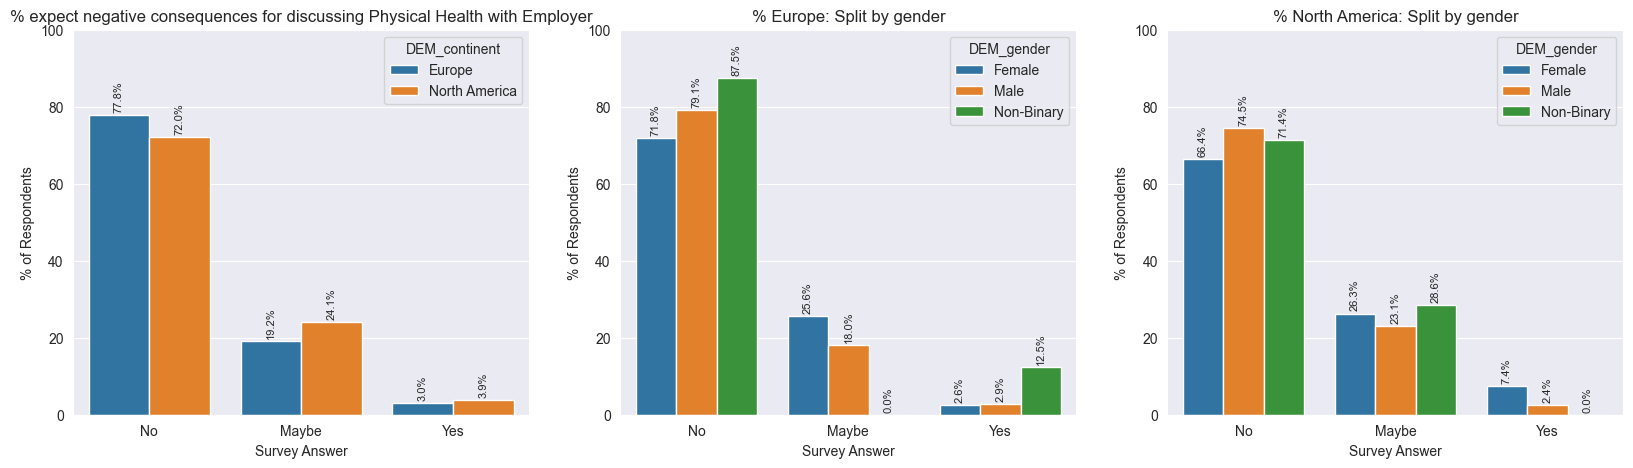

In [193]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

df_2016 = df[df['SurveyID']==2016]

# Chart 1
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe','North America'])], "DEM_continent", "STIG_neg_conseq_physical_employer"),
    x='STIG_neg_conseq_physical_employer',
    y='STIG_neg_conseq_physical_employer_pct',
    hue='DEM_continent',
    ax=ax[0]
)

ax[0].set_title("% expect negative consequences for discussing Physical Health with Employer")
#ax[0].set_ylim(0, 30)


# Chart 2
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe'])], "DEM_gender", "STIG_neg_conseq_physical_employer"),
    x='STIG_neg_conseq_physical_employer',
    y='STIG_neg_conseq_physical_employer_pct',
    hue='DEM_gender',
    ax=ax[1]
)

ax[1].set_title("% Europe: Split by gender")
#ax[1].set_ylim(0, 30)


sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['North America'])], "DEM_gender", "STIG_neg_conseq_physical_employer"),
    x='STIG_neg_conseq_physical_employer',
    y='STIG_neg_conseq_physical_employer_pct',
    hue='DEM_gender',
    ax=ax[2]
)

ax[2].set_title("% North America: Split by gender")
#ax[2].set_ylim(0, 30)



# --- Add labels for all 3 charts
for axes in [ax[0], ax[1], ax[2]]:
    for container in axes.containers:
        axes.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=8, rotation=90, padding=2)
        axes.set(ylabel='% of Respondents', xlabel='Survey Answer')
        axes.set_ylim(0, 100)

plt.subplots_adjust(hspace=0.4)



When asked whether respondents would expect negative consequnces for discussing Physical Health with Employers there's a dramatic difference.

Tech workers are far less likely to expect negative consequences for phyiscal health as oppose to mental health. This suggests there could be a stigma or unappreciation for Mental Health struggles.

## Employer & Industry Support

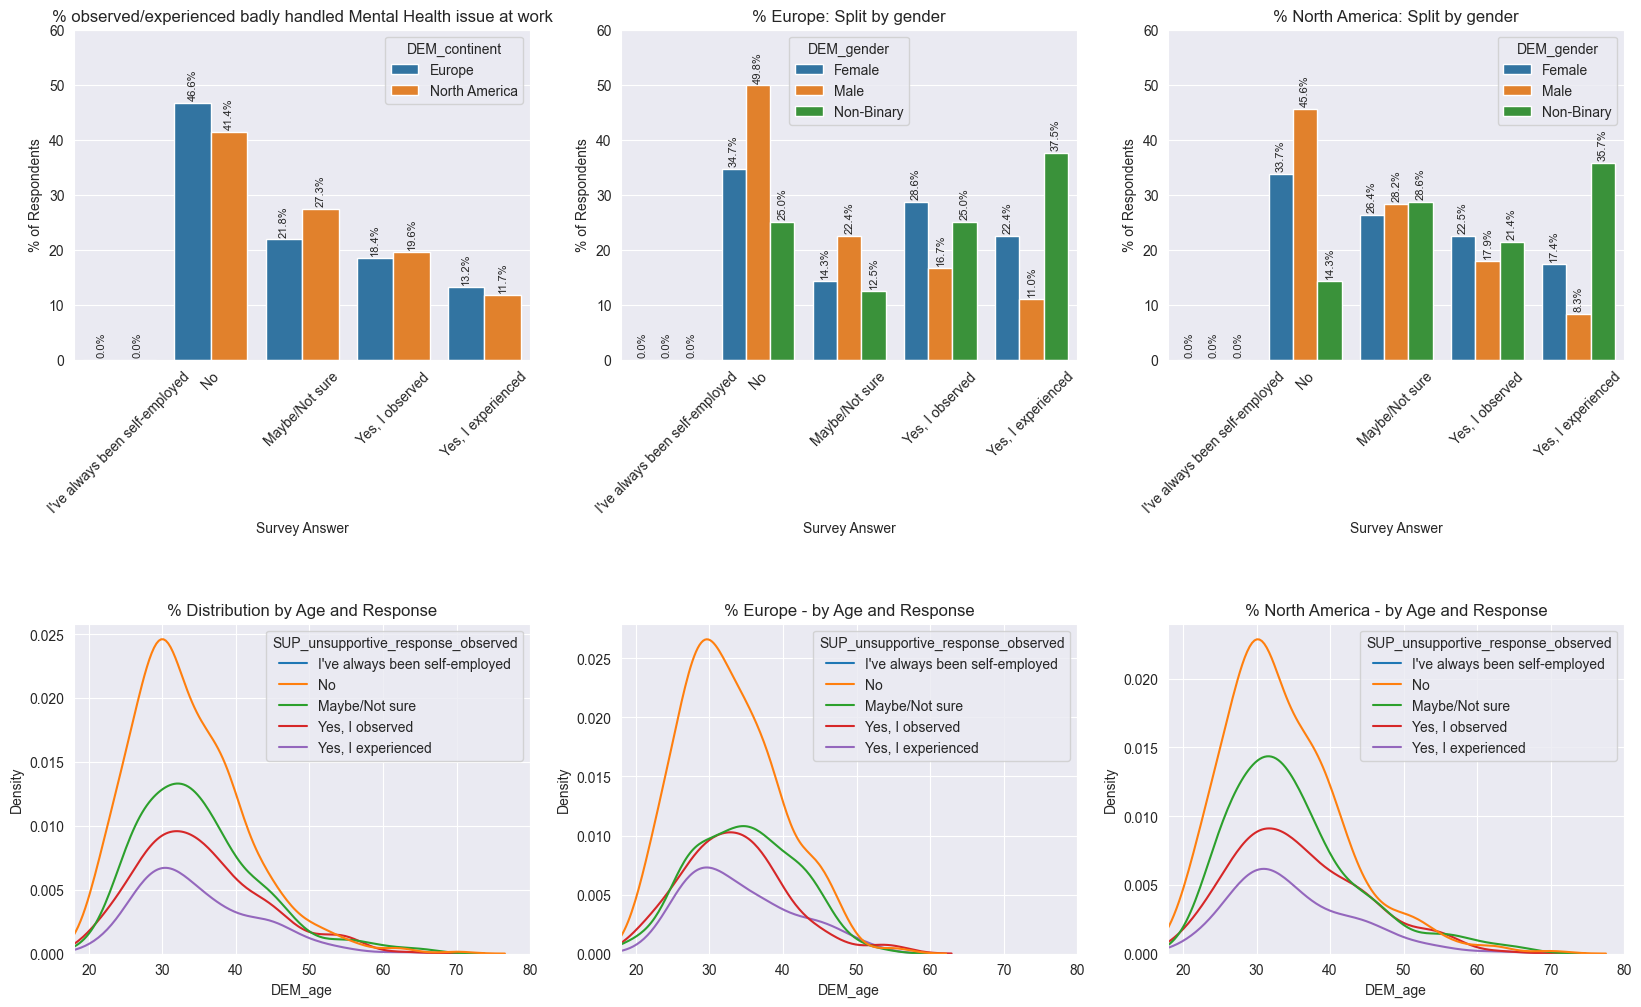

In [194]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))

# Chart 1
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe','North America'])], "DEM_continent", "SUP_unsupportive_response_observed"),
    x='SUP_unsupportive_response_observed',
    y='SUP_unsupportive_response_observed_pct',
    hue='DEM_continent',
    ax=ax[0,0]
)

ax[0,0].set_title("% observed/experienced badly handled Mental Health issue at work")
ax[0,0].set_ylim(0, 60)


# Chart 2
sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['Europe'])], "DEM_gender", "SUP_unsupportive_response_observed"),
    x='SUP_unsupportive_response_observed',
    y='SUP_unsupportive_response_observed_pct',
    hue='DEM_gender',
    ax=ax[0,1]
)

ax[0,1].set_title("% Europe: Split by gender")
ax[0,1].set_ylim(0, 60)


sns.barplot(
    data=hf.df_col_pct_grouped(df_2016[df_2016['DEM_continent'].isin(['North America'])], "DEM_gender", "SUP_unsupportive_response_observed"),
    x='SUP_unsupportive_response_observed',
    y='SUP_unsupportive_response_observed_pct',
    hue='DEM_gender',
    ax=ax[0,2]
)

ax[0,2].set_title("% North America: Split by gender")
ax[0,2].set_ylim(0, 60)


# ROW 2
# Chart 1
sns.kdeplot(
    data=df_2016[df_2016['DEM_continent'].isin(['Europe','North America'])],
    x='DEM_age',
    hue='SUP_unsupportive_response_observed',
    ax=ax[1,0]
)

ax[1,0].set_title("% Distribution by Age and Response")
ax[1,0].set_xlim(18, 80)


# Chart 2
sns.kdeplot(
    data=df_2016[df_2016['DEM_continent'].isin(['Europe'])],
    x='DEM_age',
    hue='SUP_unsupportive_response_observed',
    ax=ax[1,1]
)

ax[1,1].set_title("% Europe - by Age and Response")
ax[1,1].set_xlim(18, 80)


sns.kdeplot(
    data=df_2016[df_2016['DEM_continent'].isin(['North America'])],
    x='DEM_age',
    hue='SUP_unsupportive_response_observed',
    ax=ax[1,2]
)

ax[1,2].set_title("% North America - by Age and Response")
ax[1,2].set_xlim(18, 80)





# --- Add labels for all 3 charts
for axes in [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]:
    for container in axes.containers:
        axes.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=8, rotation=90, padding=2)
        axes.set(ylabel='% of Respondents', xlabel='Survey Answer')
        axes.tick_params(axis="x", rotation=45)

plt.subplots_adjust(hspace=0.8)



Focusing again on 2016 as a case study year, we see that most respondents—around two-thirds—reported they had not witnessed a poorly handled mental health issue at work. However, breaking this down by gender reveals a noticeable divergence:

- In both Europe and North America, about 47% of respondents said they had never witnessed a poorly managed mental health incident.
- Gender-neutral workers were nearly three times more likely, and women almost twice as likely, to have experienced such incidents compared to men.
- The median age of those who had experienced a mental health issue also skews slightly younger, though the difference is not substantial compared to other groups.

Let’s now consider alternative ways to visualise this population comparison.

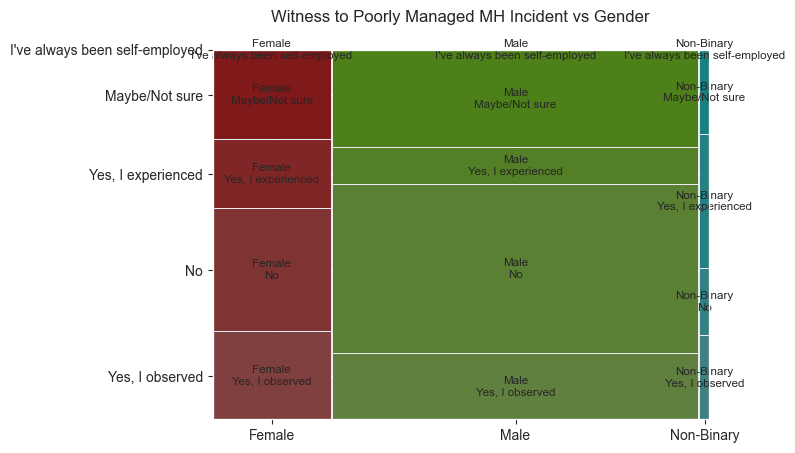

In [198]:

mosaic(
    df_2016,
    ["DEM_gender","SUP_unsupportive_response_observed"]
)

# Add title with extra padding
plt.title("Witness to Poorly Managed MH Incident vs Gender", pad=20)  # pad=20 pushes it down


plt.show()

As seen in previous charts, tech is a male dominated workforce however the split of mental health observations differs much more to men

/var/folders/kn/24kjgmss2yzfjngp_zf6x8vr0000gn/T/ipykernel_1334/3154224035.py:6: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.kdeplot(
/var/folders/kn/24kjgmss2yzfjngp_zf6x8vr0000gn/T/ipykernel_1334/3154224035.py:21: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.histplot(


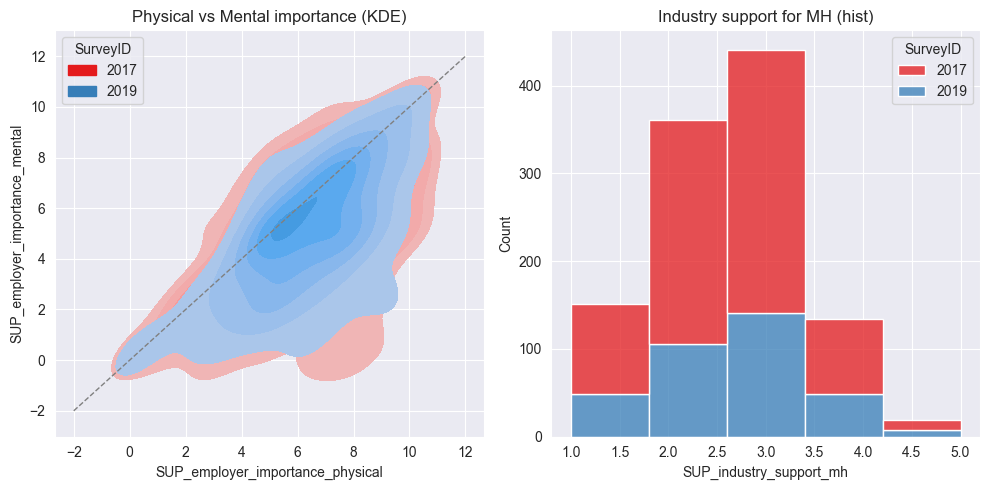

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

palette = sns.color_palette("Set1")

# Chart 1: 2D KDE with hue (replacement for jointplot inside a subplot)
sns.kdeplot(
    data=df[df['SurveyID'].isin([2017, 2019])],
    x="SUP_employer_importance_physical",
    y="SUP_employer_importance_mental",
    hue="SurveyID",
    fill=True,         # filled contours like jointplot(kind="kde")
    thresh=0.1,          # show full contour range
    common_norm=True, # keep groups on their own scale
    palette=palette,
    ax=ax[0]
)
ax[0].plot([-2, 12], [-2, 12], linestyle="--", color="gray", linewidth=1)
ax[0].set_title("Physical vs Mental importance (KDE)")

# Chart 2: histogram
sns.histplot(
    data=df[df['SurveyID'].isin([2017, 2019])],
    x='SUP_industry_support_mh',
    bins=5,
    hue='SurveyID',
    multiple='stack',   # or 'stack' if you prefer
    common_norm=False,
    palette=palette,
    ax=ax[1]
)
ax[1].set_title("Industry support for MH (hist)")


plt.tight_layout()
plt.show()


These two charts show the perceived relationship between the importance of physical and mental health, and the levels of industry support for mental health.

First chart:
- In both years (2017 in red, 2019 in blue), responses cluster strongly in the mid-to-high importance range (around values 4–8).
- The diagonal line represents a one-to-one relationship—where mental health is rated as equally important as physical health. Points below the line indicate that employers place greater importance on physical health relative to mental health.
- A higher concentration of data falls below the line, suggesting that employers tend to prioritize physical health over mental health.

Second chart:
- This chart shows the distribution of perceived industry support for mental health on a scale from 1 (Very Low) to 5 (Very High).
- The distributions are nearly identical between 2017 and 2019, indicating no meaningful progress over this period. The median value remains below 3, reflecting generally low levels of perceived support.

In [202]:
df.groupby(["SurveyID","SUP_employer_seriousness_mh_vs_physical"]).agg(count=("SUP_employer_seriousness_mh_vs_physical", "size")).sort_values(by="count", ascending=False).head(20)

count
SurveyID SUP_employer_seriousness_mh_vs_physical       
2014     Don't know                                 576
2016     Don't know                                 493
         Yes                                        350
2014     Yes                                        343
         No                                         341
2016     No                                         303

In [203]:
df.dtypes

SurveyID                                      int64
UserID                                        int64
DEM_age                                       Int32
DEM_gender                                   object
DEM_country                                  object
DEM_continent                                object
DEM_race                                     object
DEM_remote_50plus                            object
DEM_remote                                   object
DEM_position                                 object
PMH_current_mh_disorder                      object
PMH_diagnosed_mh_disorder                    object
PMH_mh_disorder_interference_treated       category
PMH_mh_affects_productivity                  object
PMH_mh_affects_work_pct                    category
PMH_openly_identified_mh                     object
PMH_mh_identification_career_effect          object
PMH_mh_condition_interference              category
DMH_comfortable_mh_coworkers                 object
DMH_comforta

## Probabilities - What's the Likelihood?

### What's the probability of being 32 in tech in 2019?
Assuming our sample population is representative of all tech workers and we were to pick an employee randomly in 2019 there was a 0.042 probability they would be 32.


In [205]:
con.execute("""

WITH base AS (
    SELECT
        a.SurveyID,
        CASE
            WHEN CAST(AnswerText AS int) NOT BETWEEN 18 AND 70 THEN NULL
            ELSE CAST(AnswerText AS int)
        END AS DEM_age,
    FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

    WHERE a.questionid = '1'
)

SELECT
    SurveyID,
    SUM(CASE WHEN DEM_age = 32 THEN 1 ELSE 0 END) AS age_32_count,
    count(*) AS vol,
    (SUM(CASE WHEN DEM_age = 32 THEN 1 ELSE 0 END) / count(*)) AS age_32_probability,

FROM base
WHERE DEM_age IS NOT NULL
GROUP BY ALL
ORDER BY 1 ASC

""").fetchdf()

,SurveyID,age_32_count,vol,age_32_probability
0,2014,82.0,1251,0.065548
1,2016,72.0,1427,0.050456
2,2017,39.0,754,0.051724
3,2018,19.0,417,0.045564
4,2019,15.0,351,0.042735


### What's the probability of being a man in tech in 2019?
Assuming our sample population is representative of all tech workers and we were to pick an employee randomly in 2019 there was a 0.67 probability it would be a man.


In [206]:
con.execute("""

WITH base AS (
    SELECT
        a.SurveyID,
        CASE
            WHEN LOWER(AnswerText) = 'male'   THEN 'Male'
            WHEN LOWER(AnswerText) = 'female' THEN 'Female'
            WHEN LOWER(AnswerText) LIKE '%binary%'
              OR LOWER(AnswerText) LIKE '%trans%'
              OR LOWER(AnswerText) LIKE '%queer%'
              OR LOWER(AnswerText) LIKE '%gender%'
            THEN 'Non-Binary'
            ELSE NULL
        END AS DEM_gender,

    FROM Answer AS a LEFT JOIN Question AS q ON a.QuestionID = q.questionid

    WHERE a.SurveyID = 2019 AND a.questionid = '2'
)

SELECT
    SurveyID,
    SUM(CASE WHEN DEM_gender = 'Male' THEN 1 ELSE 0 END) AS male_count,
    count(*) AS vol,
    (SUM(CASE WHEN DEM_gender = 'Male' THEN 1 ELSE 0 END) / count(*)) AS gender_probability,

FROM base
WHERE DEM_gender IS NOT NULL
GROUP BY ALL

""").fetchdf()

,SurveyID,male_count,vol,gender_probability
0,2019,227.0,335,0.677612


### Of being a woman and having witnesses mental health issues over the years?
Assuming our sample population is representative of all female tech workers having witnessed a mental health issue. If we were to pick an employee randomly in the year 2016 there was a 0.23 probability, in 2019 there was a 0.22 probability they'd witnessed someone with a mental health issue


In [207]:
query = duckdb.query("""
    SELECT
        SurveyID,
        (SUM(CASE WHEN DEM_gender = 'Female' AND SUP_unsupportive_response_observed = 'Yes, I observed' THEN 1 ELSE 0 END) / count(*)) AS female_witness_probability,
        COUNT(*) AS vol

    FROM df

    WHERE (DEM_gender IS NOT NULL AND SUP_unsupportive_response_observed IS NOT NULL) AND DEM_gender = 'Female'

    GROUP BY ALL

    ORDER BY 1,2,3


""").to_df()

query

,SurveyID,female_witness_probability,vol
0,2016,0.238245,319
1,2017,0.174312,218
2,2018,0.224000,125
3,2019,0.224490,98


### Of being non-binary and having experienced a mental health issues over the years?
Assuming our sample population is representative of all female tech workers having witnessed a mental health issue. If we were to pick an employee randomly in the year 2016 there was a 0.23 probability, in 2019 there was a 0.22 probability they'd witnessed someone with a mental health issue


In [208]:
query = duckdb.query("""
    SELECT
        SurveyID,
        (SUM(CASE WHEN DEM_gender = 'Non-Binary' AND SUP_unsupportive_response_observed = 'Yes, I experienced' THEN 1 ELSE 0 END) / count(*)) AS non_binary_experience_probability,
        COUNT(*) AS vol

    FROM df

    WHERE (DEM_gender IS NOT NULL AND SUP_unsupportive_response_observed IS NOT NULL) AND DEM_gender = 'Non-Binary'

    GROUP BY ALL

    ORDER BY 1


""").to_df()

query

,SurveyID,non_binary_experience_probability,vol
0,2016,0.363636,22
1,2017,0.357143,14
2,2018,0.266667,15
3,2019,0.300000,10
